# **Blending PlanetScope and Sentinel-2 imagery for seagrass change detection**
*Diclaimer: your imagery has to be atmospherically corrected, thats why we integrate ACOLITE processor into the workflow (default settings, v20231023.0). If prefered, you can also use your corrected imagery avoiding step 1 and importing them to Drive or GEE as an asset.*

*This code has been developed for the eutrophic Lagoa da Conceiçao in Florianopolis (Brazil).*

---

The code includes:
1. Sentinel-2 atmospheric correction: L1C to L2A using ACOLITE inside GEE
2. ODW and land adjacent pixels masking
3. Co-registration of Sentinel-2 images into PlanetScope grid
4. Preparation of in situ data: training and validation sets
5. Depth invariant index and band ratios calculation over Sentinel-2
6. Random Forest: binary classification
  6.1. Pre-event + uncertainty assessment
  6.2. Post-event + uncertainty assessment
7. Seagrass change quantification


> **Mar Roca Mora**
Last update: 2025/06/11



## Libraries

In [ ]:
!pip install xlsxwriter
!pip install geemap
!pip install rioxarray
!pip install earthengine-api
!pip install scikit-learn matplotlib

# 0 - Set up

In [ ]:
## Connection to GEE project
import ee
ee.Authenticate()
ee.Initialize(project='your-project')

## Connection to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


Mounted at /content/drive


In [ ]:
## Import some libraries
import os
import ee
import geemap
import geemap.colormaps as cm
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
geemap.ee_initialize()



# 1 - Atmospheric correction - ACOLITE inside GEE



In [6]:
# Set directory
%cd '/content/drive/My Drive/ACOLITE/'

# Verify directory
!pwd

/content/drive/My Drive/ACOLITE
/content/drive/My Drive/ACOLITE


In [ ]:
## Connect to ACOLITE version and import (takes aroud 1 minute)
import sys
ACOLITE_PATH = '/content/drive/My Drive/ACOLITE/20231023.0'
sys.path.append(ACOLITE_PATH)
import ACOLITE

## ACOLITE functions

In [8]:
def correct_l1s(collection):
  collection_list = collection.toList(collection.size().getInfo())
  images = []
  for i in range(collection_list.size().getInfo()):
    image = ee.Image(collection_list.get(i))
    images.append(ACOLITE.dask_spectrum_fitting(image)[0])

  return ee.ImageCollection.fromImages(images)

def water_quality(collection, products):
  for product in products:
    collection = collection.map(product)
  return collection

In [ ]:
## Sentinel-2 imagery: from L1C to L2A using ACOLITE integrated into GEE
roi = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/Lagoa_sections').geometry()

## Pre-event (2018) selected Sentinel-2 images:
pre1 = 'COPERNICUS/S2_HARMONIZED/20180308T131241_20180308T131717_T22JGQ'
pre2 = 'COPERNICUS/S2_HARMONIZED/20180316T132229_20180316T132601_T22JGQ'
pre3 = 'COPERNICUS/S2_HARMONIZED/20180425T132229_20180425T132231_T22JGQ'

sentinel2_l1c_pre = ee.ImageCollection([
    ee.Image(pre1),
    ee.Image(pre2),
    ee.Image(pre3)
])

# Convert DN to rrs and downscale to 10 meters
sentinel2_l1r_rrs_pre = sentinel2_l1c_pre.map(ACOLITE.select_sentinel2_bands).map(ACOLITE.to_rrs).map(ACOLITE.to_10m)
sentinel2_list = sentinel2_l1r_rrs_pre.toList(sentinel2_l1r_rrs_pre.size())
# Apply atmospheric correction Dark Spectrum Fitting
sentinel2_l2r_rrs_pre = correct_l1s(sentinel2_l1r_rrs_pre)
# Remove sunglint effect
sentinel2_l2r_rrs_pre_deglint = ee.ImageCollection.fromImages( [ ACOLITE.deglint_alternative(*ACOLITE.dask_spectrum_fitting( ee.Image(sentinel2_list.get(i)))) for i in range(sentinel2_l2r_rrs_pre.size().getInfo()) ] )
# Calculate water quality parameters of interest. In this case: chlorophyll-a and Suspended Particulate Matter (SPM)
sentinel2_l2w_rrs_pre = water_quality(sentinel2_l2r_rrs_pre_deglint, [ACOLITE.add_chl_re_mishra, ACOLITE.add_spm_nechad2016_665])

# Post-event (2024) selected Sentinel-2 images
post1 = 'COPERNICUS/S2_HARMONIZED/20240311T131239_20240311T131237_T22JGQ'
post2 = 'COPERNICUS/S2_HARMONIZED/20240331T131239_20240331T131627_T22JGQ'
post3 = 'COPERNICUS/S2_HARMONIZED/20240410T131239_20240410T131751_T22JGQ'

sentinel2_l1c_post = ee.ImageCollection([
    ee.Image(post1),
    ee.Image(post2),
    ee.Image(post3)
])

# Convert DN to rrs and downscale to 10 meters
sentinel2_l1r_rrs_post = sentinel2_l1c_post.map(ACOLITE.select_sentinel2_bands).map(ACOLITE.to_rrs).map(ACOLITE.to_10m)
sentinel2_list = sentinel2_l1r_rrs_post.toList(sentinel2_l1r_rrs_post.size())
# Apply atmospheric correction Dark Spectrum Fitting
sentinel2_l2r_rrs_post = correct_l1s(sentinel2_l1r_rrs_post)
# Remove sunglint effect
sentinel2_l2r_rrs_post_deglint = ee.ImageCollection.fromImages( [ ACOLITE.deglint_alternative(*ACOLITE.dask_spectrum_fitting( ee.Image(sentinel2_list.get(i)))) for i in range(sentinel2_l2r_rrs_pre.size().getInfo()) ] )
# Calculate water quality parameters of interest. In this case: chlorophyll-a and Suspended Particulate Matter (SPM)
sentinel2_l2w_rrs_post = water_quality(sentinel2_l2r_rrs_post_deglint, [ACOLITE.add_chl_re_mishra, ACOLITE.add_spm_nechad2016_665])

print('Proccessed!')
print('Number of images processed pre-event:', sentinel2_l2w_rrs_pre.size().getInfo())
print('Number of images processed post-event:', sentinel2_l2w_rrs_post.size().getInfo())

In [10]:
## A 'constant' band is automatically generated. Remove it from the Image Collections
band_names = sentinel2_l2w_rrs_pre.first().bandNames()

# Select all bands except the constant band
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.select(band_names.filter(ee.Filter.neq('item', 'constant'))))
sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.select(band_names.filter(ee.Filter.neq('item', 'constant'))))

In [11]:
## Clip Image Collections
# pre-event
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.clip(roi.dissolve()))
# post-event
sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.clip(roi.dissolve()))

first_image = sentinel2_l2w_rrs_pre.first()
band_names = first_image.bandNames()

print(band_names.getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'chl_re_mishra', 'SPM_Nechad2016_665']


In [12]:
# This method can also be used for a multi-temporal approach

# # Range of images used for the multi-temporal composite pre-processing stack
# start = '2018-02-01'
# end = '2018-04-30'
# tile = '22JGQ'
# bounds = [-48.490219, -27.634741, -48.423615, -27.509432]

# sentinel2_l1c_pre_multitemporal = ACOLITE.search_with_clouds(roi, start, end, tile = tile)

## APPLY REDUCER
# reduce(ee.Reducer.percentile([ee.Number(20))])

In [ ]:
# Display imagery in map
rgb_plot_s2 = {
    'bands': ['B4', 'B3', 'B2'],
    'gamma': 1.4,
    'min': -0.0015375894198130027,
    'max': 0.0883948298123742}

Map = geemap.Map()
Map.addLayer(sentinel2_l2w_rrs_post.first(), rgb_plot_s2, "Sentinel-2 L2")
Map

In [15]:
# # Export to Drive
# task = ee.batch.Export.image.toDrive(
#     image=sentinel2_l2w_rrs_post.first(),
#     description='S2L2A_post',
#     region=roi.dissolve(),
#     folder= "/content/drive/My Drive/Colab_Notebooks/export",
#     fileFormat = "GeoTIFF",
#      maxPixels = 1e13
# )

# task.start()
# print('Exported!')


# 2 - Optically deep water (ODW) and land pixel masking

In [16]:
# For the ODW masking we used a delimitation from 1-meter secchi disk for 2024 processed for Sentinel-2 imagery.
OSW = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/OSW_zSD_new')
bathy = ee.Image('projects/ee-seagrass-mar/assets/Brazil/Batimetria_Lagoa')

In [ ]:
ndwi24 = sentinel2_l2w_rrs_post.first().normalizedDifference(['B8', 'B4'])
land_mask = ndwi24.lt(0.1)

Map.addLayer(land_mask, {'palette': 'orange'}, "Land Mask 24")
# Map.addLayer(OSW, {'color': 'yellow'}, "OSW")
# Map.centerObject(land_mask, 11)
# Map

zSD = ee.Image('projects/ee-seagrass-mar/assets/Brazil/PlanetScope_24').select('zSD')
zSD = zSD.updateMask(zSD.lte(1))
land_mask = ndwi24.lt(0.1).And(zSD.lte(1))
Map.addLayer(land_mask, {'palette': 'orange'}, "Shallow water mask")
# Map.centerObject(land_mask, 11)
# Map

Map.addLayer(zSD, {"min":0,"max":1,"palette":["e0f7fa","b2ebf2","81d4fa","4fc3f7","29b6f6","039be5","0288d1","0277bd","01579b","003f5c"]}, "zSD")
Map.centerObject(zSD, 11)
Map

In [19]:
# # Export to Drive
# task = ee.batch.Export.image.toDrive(
#     image=land_mask.clip(OSW),
#     description='mask',
#     region=roi.dissolve(),
#     folder= "/content/drive/My Drive/Colab_Notebooks/export",
#     fileFormat = "GeoTIFF",
#      maxPixels = 1e13
# )

# task.start()
# print('Exported!')

In [20]:
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.updateMask(land_mask).clip(OSW))
sentinel2_l2w_rrs_pre = sentinel2_l2w_rrs_pre.map(lambda image: image.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'chl_re_mishra', 'SPM_Nechad2016_665']))
                                                  #.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'chl_re_mishra', 'SPM_Nechad2016_665']))
band_names = sentinel2_l2w_rrs_pre.first().bandNames()

sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.updateMask(land_mask).clip(OSW))
sentinel2_l2w_rrs_post = sentinel2_l2w_rrs_post.map(lambda image: image.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'chl_re_mishra', 'SPM_Nechad2016_665']))
                                                    #.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'chl_re_mishra', 'SPM_Nechad2016_665']))

rgb_plot_s2 = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.5,
    'gamma': 1.4
}


Map.addLayer(sentinel2_l2w_rrs_pre.first(), rgb_plot_s2, "S2 OSW")
Map.centerObject(land_mask, 11)
Map

Map(center=[-27.569716376918034, -48.454041154442216], controls=(WidgetControl(options=['position', 'transpare…


# 3 - Replace names

In [21]:
def rename(image):
    # Rename bands
    s2_prefix = 'S2_'
    # Select all bands in the image and then rename them
    renamed_image = image.select(image.bandNames()).rename(image.bandNames().map(lambda band: ee.String(s2_prefix).cat(band)))
    return renamed_image

multi_sensor_pre = sentinel2_l2w_rrs_pre.map(rename)
multi_sensor_post = sentinel2_l2w_rrs_post.map(rename)

In [22]:
multi_sensor_pre = multi_sensor_pre.map(lambda image: image.updateMask(land_mask).clip(OSW))
multi_sensor_post = multi_sensor_post.map(lambda image: image.updateMask(land_mask).clip(OSW))

# Print band names for the first image in the collection
first_image = multi_sensor_pre.first()
band_names = first_image.bandNames()
band_names.getInfo()

['S2_B1',
 'S2_B2',
 'S2_B3',
 'S2_B4',
 'S2_B5',
 'S2_B6',
 'S2_B7',
 'S2_B8',
 'S2_chl_re_mishra',
 'S2_SPM_Nechad2016_665']

In [23]:
multi_sensor_pre

Output hidden; open in https://colab.research.google.com to view.

# 4 - Preparation of *in situ* data: training and validation sets

Field sample data have the following classes as 'Bottom':

 0 - seagrass (Halodule or Ruppia)

 1 - nonSeagrass (sand, mud, rock, algae)

In [ ]:

insitu2018 = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/fieldData18').filterBounds(OSW)
sand18 = insitu2018.filter(ee.Filter.eq('Bottom', 'sand'))
# print('Total samples 2018:', insitu2018.size().getInfo())
# print('Sand sample 2018:',sand18.size().getInfo())

# in situ 2024 has 6 different bottom types: sand, mud, rock, algae, Halodule and Ruppia species, so we'll group them later ['Halodule, 'Ruppia'] == seagrass
insitu2024 = ee.FeatureCollection('projects/ee-seagrass-mar/assets/Brazil/fieldData24').filterBounds(OSW)

# Filter for sand class and get size on the server side
sand24 = insitu2024.filter(ee.Filter.eq('Bottom', 'sand'))
# seagrass24 = insitu2024.filter(ee.Filter.inList('Bottom', ['Halodule', 'Ruppia'])) # Keep this commented out as it was before
# print('Total samples 2024:', insitu2024.size().getInfo())
# print('Sand sample 2024:', sand24.size().getInfo())
# print('Seagrass sample 2024:',seagrass24.size().getInfo()) # Keep this commented out as it was before
insitu2018

In [ ]:
Map.addLayer(insitu2018, {'color': 'darkgreen'}, 'in situ 2018')
Map.addLayer(insitu2024, {'color': 'lightgreen'}, 'in situ 2024')
# Map.addLayer(land_mask, {'color': 'blue'}, 'secchi_mask')
Map

In [26]:
# Extract spectral data for each band for the whole the collection
def sample_image_pre(image):
    sampled = image.sampleRegions(
        collection=insitu2018,
        properties=['Bottom'],
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(image.bandNames()))
    return sampled

# Map the sampling function to the ImageCollection
sampled_fc_list = multi_sensor_pre.map(sample_image_pre).toList(multi_sensor_pre.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledData_2018 = ee.FeatureCollection(sampled_fc_list).flatten()


# print('sampledData 2018:', sampledData_2018.size().getInfo())

def sample_image_post(image):
    sampled = image.sampleRegions(
        collection=insitu2024,
        properties=['Bottom'],
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(image.bandNames()))
    return sampled

# Map the sampling function to the ImageCollection
sampled_fc_list = multi_sensor_post.map(sample_image_post).toList(multi_sensor_post.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledData_2024 = ee.FeatureCollection(sampled_fc_list).flatten()


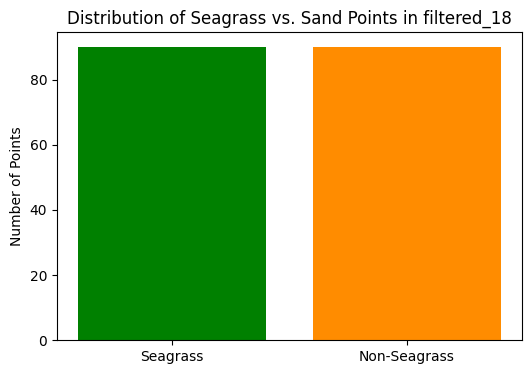

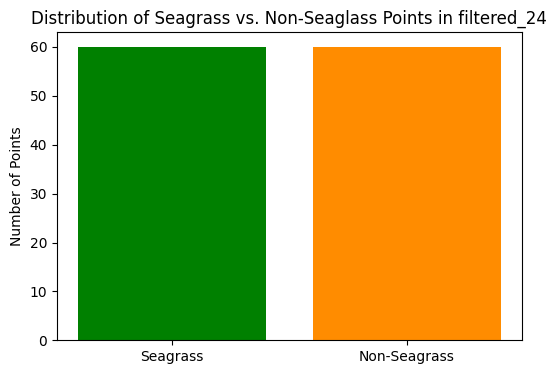

In [28]:
## Split training and validation sets ## Be sure in a Random Forest that the dataset is balanced (50%/50% of each class)
## 2018
filtered_18_seagrass = insitu2018.filter(ee.Filter.eq('Bottom', 'seagrass')).randomColumn('random')
filtered_18_nonSeagrass = insitu2018.filter(ee.Filter.eq('Bottom', 'sand')).randomColumn('random')

# Get the count of seagrass and sand points in filtered_18
seagrass_samples_18 = filtered_18_seagrass.limit(90)
nonSeagrass_samples_18 = filtered_18_nonSeagrass.limit(90)

seagrass_count_18 = seagrass_samples_18.size().getInfo()
nonSeagrass_count_18 = nonSeagrass_samples_18.size().getInfo()

# Create labels and counts for the bar chart
labels = ['Seagrass', 'Non-Seagrass']
counts = [seagrass_count_18, nonSeagrass_count_18]

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['green', 'darkorange'])
plt.ylabel('Number of Points')
plt.title('Distribution of Seagrass vs. Sand Points in filtered_18')
plt.show()

## 2024
filtered_24_seagrass = insitu2024.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).randomColumn('random')
filtered_24_nonSeagrass = insitu2024.filter(ee.Filter.inList('Bottom', ['sand',  'mud'])).randomColumn('random')

## 2024
# Separate features by class groupings
seagrass_samples_24 = filtered_24_seagrass.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).limit(60)
nonSeagrass_samples_24 = filtered_24_nonSeagrass.filter(ee.Filter.inList('Bottom', ['sand',  'mud', 'rock', 'algae'])).limit(60) # Adjust this list based on your non-seagrass classes

# Get the count of seagrass and non-seagrass points in filtered_24
seagrass_count_24 = seagrass_samples_24.size().getInfo()
nonSeagrass_count_24 = nonSeagrass_samples_24.size().getInfo()

# Create labels and counts for the bar chart
labels = ['Seagrass', 'Non-Seagrass']
counts = [seagrass_count_24, nonSeagrass_count_24]

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['green', 'darkorange'])
plt.ylabel('Number of Points')
plt.title('Distribution of Seagrass vs. Non-Seaglass Points in filtered_24')
plt.show()

In [29]:
## Split training and validation sets
## 2018
t_seagrass_pre = seagrass_samples_18.filter(ee.Filter.eq('Bottom', 'seagrass')).filter(ee.Filter.lt('random', 0.7))
v_seagrass_pre = seagrass_samples_18.filter(ee.Filter.eq('Bottom', 'seagrass')).filter(ee.Filter.gte('random', 0.7))
t_nonSeagrass_pre = nonSeagrass_samples_18.filter(ee.Filter.eq('Bottom', 'sand')).filter(ee.Filter.lt('random', 0.7))
v_nonSeagrass_pre = nonSeagrass_samples_18.filter(ee.Filter.eq('Bottom', 'sand')).filter(ee.Filter.gte('random', 0.7))
validation_pre = v_seagrass_pre.merge(v_nonSeagrass_pre)
print('Training pre:', t_seagrass_pre.merge(t_nonSeagrass_pre).size().getInfo())
print('t_seagrass_pre:', t_seagrass_pre.size().getInfo())
print('t_nonSeagrass_pre:', t_nonSeagrass_pre.size().getInfo())
print('Validation pre:', validation_pre.size().getInfo())
print('v_seagrass_pre:', v_seagrass_pre.size().getInfo())
print('v_nonSeagrass_pre:', v_nonSeagrass_pre.size().getInfo())

## 2024
t_seagrass_post = seagrass_samples_24.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).filter(ee.Filter.lt('random', 0.7))
v_seagrass_post = seagrass_samples_24.filter(ee.Filter.inList('Bottom', ['Hadolule', 'Ruppia'])).filter(ee.Filter.gte('random', 0.7))
t_nonSeagrass_post = nonSeagrass_samples_24.filter(ee.Filter.inList('Bottom', ['sand',  'mud'])).filter(ee.Filter.lt('random', 0.7)) ##['sand', 'rock', 'mud', 'algae']))
v_nonSeagrass_post = nonSeagrass_samples_24.filter(ee.Filter.inList('Bottom', ['sand', 'mud'])).filter(ee.Filter.gte('random', 0.7)) ## Try including only sand and mud
validation_post = v_seagrass_post.merge(v_nonSeagrass_post)
print('Training post:', t_seagrass_post.merge(t_nonSeagrass_post).size().getInfo())
print('t_seagrass_post:', t_seagrass_post.size().getInfo())
print('t_nonSeagrass_post:', t_nonSeagrass_post.size().getInfo())
print('Validation post:', v_seagrass_post.merge(v_nonSeagrass_post).size().getInfo())
print('v_seagrass_post:', v_seagrass_post.size().getInfo())
print('v_nonSeagrass_post:', v_nonSeagrass_post.size().getInfo())

Training pre: 126
t_seagrass_pre: 61
t_nonSeagrass_pre: 65
Validation pre: 54
v_seagrass_pre: 29
v_nonSeagrass_pre: 25
Training post: 89
t_seagrass_post: 42
t_nonSeagrass_post: 47
Validation post: 31
v_seagrass_post: 18
v_nonSeagrass_post: 13


In [30]:
multi_sensor_post

Output hidden; open in https://colab.research.google.com to view.

# 5 - Depth Invariant Index (DII) - B2B3 for both sensors

In [31]:
def S2_depthInvariant_pre(image):
  band1 = ['S2_B1', 'S2_B2', 'S2_B1']
  band2 = ['S2_B2', 'S2_B3', 'S2_B3']
  nband = ['S2_B1B2', 'S2_B2B3', 'S2_DII']

  for i in range(3):
    x = band1[i]
    y = band2[i]
    z = nband[i]

    imageLog = image.select([x, y]).log()

    sand = insitu2018.filter(ee.Filter.eq('Bottom', 'sand'))

    covariance = imageLog.toArray().reduceRegion(
        reducer=ee.Reducer.covariance(),
        geometry=sand,
        scale=3,
        maxPixels=1e13,
        bestEffort=True
    )

    covarMatrix = ee.Array(covariance.get('array'))
    var1 = covarMatrix.get([0, 0])
    var2 = covarMatrix.get([1, 1])
    covar = covarMatrix.get([0, 1])

    a = (var1.subtract(var2)).divide(covar.multiply(2))
    attenCoeffRatio = a.add(((a.pow(2)).add(1)).sqrt())

    depthInvariantIndex = image.expression(
        'image1 - (image2 * coeff)', {
            'image1': imageLog.select([x]),
            'image2': imageLog.select([y]),
            'coeff': attenCoeffRatio
        }
    )

    image = image.addBands(depthInvariantIndex.select([x], [z]))

  return image

def S2_depthInvariant_post(image):
  band1 = ['S2_B1', 'S2_B2', 'S2_B1']
  band2 = ['S2_B2', 'S2_B3', 'S2_B3']
  nband = ['S2_B1B2', 'S2_B2B3', 'S2_DII']

  for i in range(3):
    x = band1[i]
    y = band2[i]
    z = nband[i]

    imageLog = image.select([x, y]).log()

    sand = insitu2024.filter(ee.Filter.eq('Bottom', 'sand'))

    covariance = imageLog.toArray().reduceRegion(
        reducer=ee.Reducer.covariance(),
        geometry=sand,
        scale=3,
        maxPixels=1e13,
        bestEffort=True
    )

    covarMatrix = ee.Array(covariance.get('array'))
    var1 = covarMatrix.get([0, 0])
    var2 = covarMatrix.get([1, 1])
    covar = covarMatrix.get([0, 1])

    a = (var1.subtract(var2)).divide(covar.multiply(2))
    attenCoeffRatio = a.add(((a.pow(2)).add(1)).sqrt())

    depthInvariantIndex = image.expression(
        'image1 - (image2 * coeff)', {
            'image1': imageLog.select([x]),
            'image2': imageLog.select([y]),
            'coeff': attenCoeffRatio
        }
    )

    image = image.addBands(depthInvariantIndex.select([x], [z]))

  return image

# Apply to your image collection (e.g., multi_sensor_pre or multi_sensor_post)
multi_sensor_pre = multi_sensor_pre.map(S2_depthInvariant_pre)
multi_sensor_post = multi_sensor_post.map(S2_depthInvariant_post)

In [32]:
multi_sensor_post

Output hidden; open in https://colab.research.google.com to view.

# 6 - Binary classification

## 6.1 - Pre-event Multi-sensor Image Collection
#### Before processing all data, the best seagrass probability threshold was studied and set as t = 45

In [33]:
# Binary classification setup
seagrass_class = 0
nonSeagrass_class = 1

# Classification and validation parameters
trees = 50
t = 45

# Boxcar kernel: a square matrix where all values are equal, and it calculates the mean of the pixel values within that square neighborhood.
boxcar = ee.Kernel.square(radius=2, units='pixels', normalize=True)
bands = multi_sensor_pre.first().bandNames()

def boxcar_image(image):
    return image.convolve(boxcar)

# Apply the function to every image in the collection
classificationComp_pre = multi_sensor_pre.map(boxcar_image)
classificationComp_pre

Output hidden; open in https://colab.research.google.com to view.

 ##### 6.1.1 - Prepare training dataset

In [34]:
# Training data - class property recoding and merging - MODEL 1 (PRE-EVENT)
t_seagrass = t_seagrass_pre.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [seagrass_class])))
t_nonSeagrass = t_nonSeagrass_pre.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [nonSeagrass_class])))
t_FC = t_seagrass.merge(t_nonSeagrass)


# Collect sampled features from each image
def sample_image(image):
    sampled = image.sampleRegions(
        collection=t_FC,
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(bands))

    return sampled

# Map the sampling function and convert result to a list of FeatureCollections
sampled_fc_list = classificationComp_pre.map(sample_image).toList(classificationComp_pre.size())
sampled_fc_list
# Flatten the FeatureCollections into one big FeatureCollection
sampledData = ee.FeatureCollection(sampled_fc_list).flatten()

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
print('sampledData:', sampledData.size().getInfo())
print('t_FC:', t_FC.size().getInfo())

sampledData: 351
t_FC: 126


6.1.2 - Extract probabilities for each class and train classifier

{'S2_B1': 27.61037961229847, 'S2_B1B2': 30.932185396750537, 'S2_B2': 29.946938176294566, 'S2_B2B3': 29.21359567222453, 'S2_B3': 29.585419206929554, 'S2_B4': 23.192612985252012, 'S2_B5': 29.047850887909885, 'S2_B6': 27.693974788961082, 'S2_B7': 35.059923549570215, 'S2_B8': 34.65961441868401, 'S2_DII': 33.05873430034875, 'S2_SPM_Nechad2016_665': 31.70925938355735, 'S2_chl_re_mishra': 33.69521064225638}


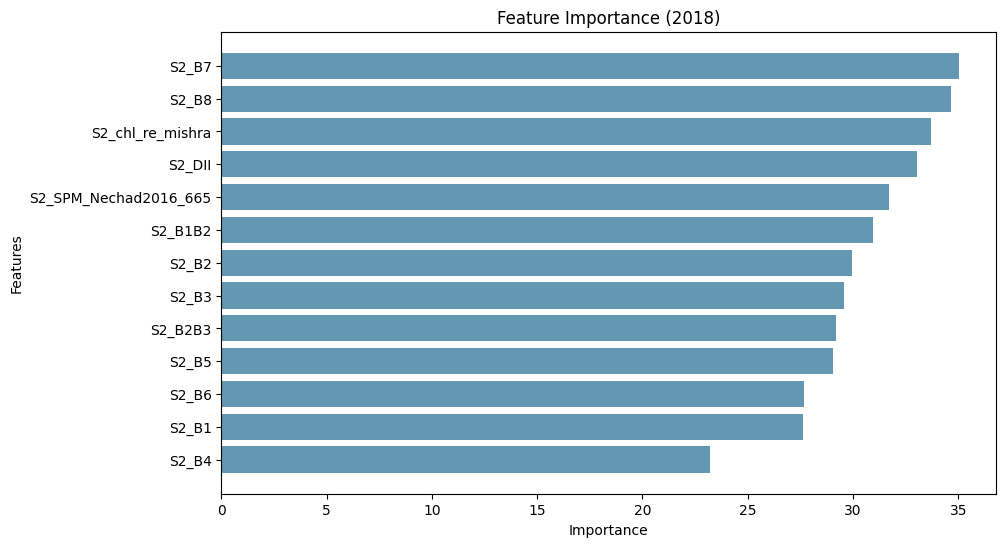

Selected bands: ['S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


<Figure size 640x480 with 0 Axes>

In [36]:
## To extract feature importance and evaluate
def soft_prob_subfn(image, num):
       training = sampledData.map(lambda ft: ft.set(
        'prob',
        ee.Algorithms.If(ft.getNumber('habitat').eq(num), 1, 0)
        ))

       trained = ee.Classifier.smileRandomForest(numberOfTrees=trees) \
           .train(training, 'prob', image.bandNames()) \
           .setOutputMode('PROBABILITY')

       dict_classifier = trained.explain()

       # Create a Feature with the dictionary as a property
       feature = ee.Feature(None, {'classifier_explanation': dict_classifier})

       # Classify and convert to percentage scale
       classified = image.classify(trained).multiply(100).toInt8()

       # Return both the classified image and the Feature with explanation
       return ee.Image(classified).set('classifier_explanation', feature)

# Map the function to your ImageCollection
seagrass_prob_IC = classificationComp_pre.map(lambda img: soft_prob_subfn(img, seagrass_class))
nonSeagrass_prob_IC = classificationComp_pre.map(lambda img: soft_prob_subfn(img, nonSeagrass_class))


### MEAN FEATURE IMPORTANCE
# Get the first three images from the ImageCollection
first_three_images = seagrass_prob_IC.toList(3)

# Initialize an empty dictionary to store feature importances
mean_importance = {}

# Iterate through the first three images
for i in range(3):
  image = ee.Image(first_three_images.get(i))
  classifier_explanation = image.get('classifier_explanation').getInfo()['properties']['classifier_explanation']
  importance_dict = classifier_explanation.get('importance')

  # Accumulate feature importances
  for feature, importance in importance_dict.items():
    mean_importance[feature] = mean_importance.get(feature, 1) + importance

# Calculate the mean feature importance
for feature in mean_importance:
  mean_importance[feature] /= 3

# Print the mean feature importance
print(mean_importance)

# Sort features by importance in descending order
sorted_importance = dict(sorted(mean_importance.items(), key=lambda item: item[1], reverse=False))

# Extract feature names and importance values
feature_names = list(sorted_importance.keys())
importance_values = list(sorted_importance.values())

# Create a list of colors based on feature name prefix
colors = ['#005b96' if name.startswith('PS_') else '#6497b1' for name in feature_names]

# Create the horizontal bar graph (switched axes)
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.barh(feature_names, importance_values, color=colors) # Changed to barh for horizontal bars
plt.ylabel("Features") # Switched x and y labels
plt.xlabel("Importance") # Switched x and y labels
plt.title("Feature Importance (2018)")
# plt.axvline(x=10.5, linestyle='dotted', color='grey')  # Add dotted vertical line
plt.show()  # Display the plot
plt.tight_layout()

selected_bands = [band for band, importance in mean_importance.items() if importance >= 0] ## Use only selected bands for the classification ## 10.5 before

print("Selected bands:", selected_bands)

Analyse covariance between variables

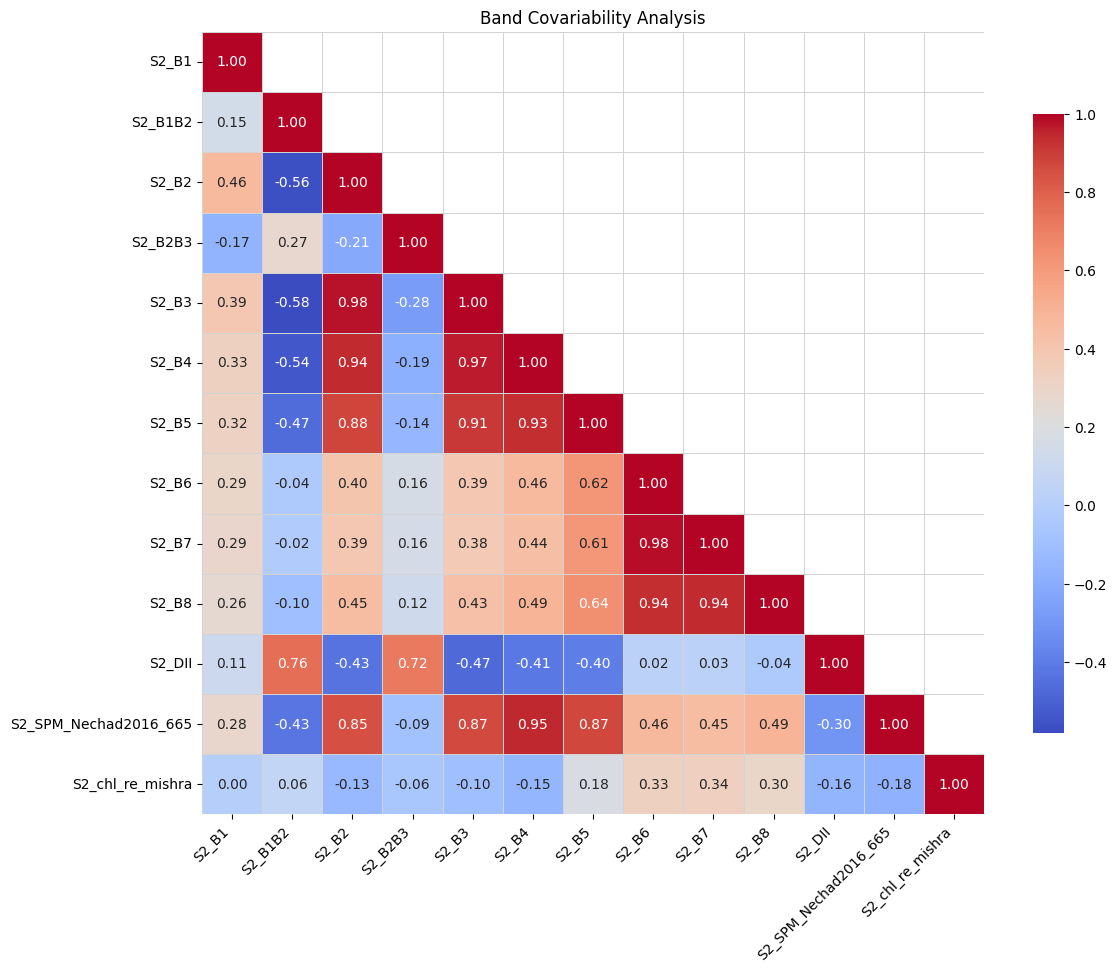

Bands to keep: ['S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


In [37]:
## Co-variance analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to extract band values from a FeatureCollection
def extract_band_values(feature_collection, bands):
    data = feature_collection.toList(feature_collection.size()).map(lambda feature: ee.Feature(feature).toDictionary().select(bands)).getInfo()
    df = pd.DataFrame(data)
    return df

# Extract band values for selected bands
band_values_df = extract_band_values(sampledData, selected_bands)

# Calculate the correlation matrix
correlation_matrix = band_values_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, bool), k=1)

# Apply the mask to the filtered correlation matrix
filtered_correlation_matrix = correlation_matrix.mask(mask)
filtered_correlation_matrix = filtered_correlation_matrix[np.abs(correlation_matrix) > 0.80]

# Get bands with at least one correlation above 0.9
bands_to_keep = filtered_correlation_matrix.columns[filtered_correlation_matrix.any()]

# Filter the original correlation matrix to keep only relevant bands
filtered_correlation_matrix = correlation_matrix.loc[bands_to_keep, bands_to_keep]

# Plot only the lower triangle of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            fmt=".2f", linewidths=.5, linecolor='lightgrey', square=True,
            cbar_kws={"shrink": .75})
plt.title('Band Covariability Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Bands to keep:", bands_to_keep.tolist())

In [38]:
# # Define the bands to remove
# bands_to_remove = ['S2_B1']

# # Create a list of bands to keep by filtering out the bands to remove
# selected_bands = [band for band in selected_bands if band not in bands_to_remove]

# # Apply the select method to the Image Collection to keep the desired bands
# classificationComp_pre = classificationComp_pre.select(selected_bands)
# classificationComp_pre.first().bandNames()
# classificationComp_pre

6.1.3 - Generate probability layers

In [39]:
## Train classifier and display probability map for seagrasses
# Define classes dictionary
classes = {
  'classes_values': [seagrass_class, nonSeagrass_class],
  'classes_names': ['seagrass','nonSeagrass']
}

classes

# Assume this is already defined:
# - classificationComp_pre: an ImageCollection
# - classes: dictionary with class values and names
# - soft_prob_subfn(image, class_id): returns a probability image for one class

def classify_with_all_classes(image):
    # Classify image for each class and rename the result accordingly
    classified_images = ee.List(classes['classes_values']).map(
        lambda class_id: soft_prob_subfn(image, class_id)
    )

    # Convert list of images into one multi-band image (each class as band)
    classified_combined = ee.ImageCollection(classified_images).toBands()
    classified_combined = classified_combined.rename(classes['classes_names'])

    # Preserve metadata if needed
    return classified_combined.copyProperties(image, image.propertyNames())

# Generate probabilities in the ImageCollection
probabilities = classificationComp_pre.map(classify_with_all_classes)
probabilities

Output hidden; open in https://colab.research.google.com to view.

Plot probabilities:

In [40]:
# Visualize probabilities
first_prob = ee.Image(probabilities.toList(probabilities.size()).get(0))
Map = geemap.Map()
Map.addLayer(first_prob.select('seagrass'), {'min': 45, 'max': 100}, 'Seagrass Prob')
Map.addLayer(first_prob.select('nonSeagrass'), {'min': 45, 'max': 100}, 'NonSeagrass Prob')
Map.centerObject(probabilities.first(), zoom=12)
Map

Map(center=[-27.574341771932055, -48.45318139273357], controls=(WidgetControl(options=['position', 'transparen…

6.1.4 - Threshold classes based on probabilities and classify

In [41]:
# Based on the generated probabilities, apply thresholding for seagrass and nonSeagrass on the whole Image Collection

# Threshold function for seagrass
def threshold_seagrass(image):
    return image.select('seagrass').updateMask(image.select('seagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Threshold function for non-seagrass
def threshold_non_seagrass(image):
    return image.select('nonSeagrass').updateMask(image.select('nonSeagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Map the thresholding over the probabilities collection
seagrass_soft = probabilities.map(threshold_seagrass)
nonSeagrass_soft = probabilities.map(threshold_non_seagrass)
nonSeagrass_soft

# Function to combine seagrass and nonSeagrass into one image
def add_bands(image):
    matching_non_seagrass = nonSeagrass_soft.filter(
        ee.Filter.eq('system:index', image.get('system:index'))
    ).first()

    # If no match is found, return image as-is
    combined = ee.Image(image).addBands(ee.Image(matching_non_seagrass))
    return combined.copyProperties(image, image.propertyNames())

# Map the function to seagrass_soft collection to create the aggregated collection
soft_map = seagrass_soft.map(add_bands)

## APPLY IN THE END TO REMOVE NOISE

# # To remove patches smaller than ~1 pixel
# min_pixels = 1  # if your resolution is ~10m
# def remove_small_patches(image):
#     # Count connected pixels
#     patch_size = image.connectedPixelCount(maxSize=100, eightConnected=True)

#     # Create a mask where patches meet the minimum size
#     cleaned = image.updateMask(patch_size.gte(min_pixels))

#     return cleaned.copyProperties(image, image.propertyNames())

# # Assuming soft_map_th is your classification collection with 'classification' band
# soft_map_th_cleaned = seagrass_soft.map(remove_small_patches)

# # Visualize probabilities
# seagrass_soft_first = ee.Image(soft_map.first().select('seagrass'))
# Map = geemap.Map()
# Map.addLayer(seagrass_soft_first, {'min': 0, 'max': 100}, 'Seagrass Prob')
# Map.centerObject(seagrass_soft_first, zoom=12)
# Map

6.1.5 - Perform classification

In [42]:
def soft_to_hard(image):
    seagrass = image.select('seagrass')
    non_seagrass = image.select('nonSeagrass')
    prob_aoi = ee.Image(probabilities.first()).geometry()

    # Get the corresponding images from seagrass_soft and nonSeagrass_soft using system:index
    seagrass_soft_image = seagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()
    nonSeagrass_soft_image = nonSeagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()

    classified = (ee.Image.constant(2)
        .where(seagrass.gte(t), ee.Number(0).add(1))  # temporary +1 to mask 0s
        .where(non_seagrass.gte(t), ee.Number(1).add(1))
        .selfMask()
        .subtract(1)  # back to 0 and 1
        .rename('classification')
        .clip(prob_aoi))

    return classified.copyProperties(image, image.propertyNames())

# Apply to soft_map
soft_map_th = soft_map.map(soft_to_hard)

In [43]:
# ## Export
# image_to_export = soft_map_th.first()
# # Define the export task
# task = ee.batch.Export.image.toDrive(
#     image=image_to_export,
#     description='soft_map_th_first',  # Description for the task
#     folder='Colab_Notebooks/export',  # Folder in Google Drive to save the image
#     fileNamePrefix='soft_map_th_first',  # Prefix for the file name
#     region=roi,  # Region of interest
#     scale=3,  # Scale in meters
#     fileFormat='GeoTIFF',  # File format
#     maxPixels=1e13  # Maximum number of pixels allowed (adjust if needed)
# )
# # Start the export task
# task.start()
# print('Export task started. You can monitor its progress in the "Tasks" tab.')

6.1.6 - Combine the three classifications for visualization

In [44]:
# 1. Extract the 'classification' band from each image
classification_images_pre = soft_map_th.select('classification')

# 2. Calculate the mean value
combined_classification_pre = classification_images_pre.mean().mask(land_mask).clip(OSW) #.selfMask()
# print(combined_classification.getInfo())

# Display the combined classification
Map.addLayer(combined_classification_pre, {'min': 0, 'max': 1, 'palette': ['42762f', '7cb75a', 'e2e9ab', 'ffffff']}, 'Combined Classification')
Map

Map(center=[-27.574341771932055, -48.45318139273357], controls=(WidgetControl(options=['position', 'transparen…

In [45]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=combined_classification_pre,
#     description='combined_classification_pre',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

In [46]:
# Apply conditional classification for obtain the final binary map
final_classification_pre = combined_classification_pre.expression(
    'b(0) < 0.35 ? 0 : 1',  # Conditional expression
    {'classification': combined_classification_pre}  # Band name mapping
).rename('classification')  # Rename the band

# Display the combined classification
Map.addLayer(final_classification_pre.mask(land_mask).clip(OSW.geometry()), {'min': 0, 'max': 1, 'palette': ['42762f', 'ffffff']}, 'Combined Classification')

6.1.7 - Validation and accuracy assessment for each of the 3 classifications

In [47]:
# Validation function
def valid_habitat(number):
  def wrap(feature):
    return feature.setMulti(ee.Dictionary.fromLists(['habitat'], [number]))
  return wrap

## Validation data
v_seagrass = v_seagrass_pre.map(valid_habitat(seagrass_class))
v_nonSeagrass = v_nonSeagrass_pre.map(valid_habitat(nonSeagrass_class))
v_FC = v_seagrass.merge(v_nonSeagrass)
v_FC

In [48]:
# Collect sampled features from each image
def validation(image):
    # Buffer the validation points by 10 meters (optional, keep if desired)
   # buffered_v_FC = v_FC.map(lambda feature: feature.buffer(5))

    sampled = image.sampleRegions(
        collection=v_FC,
        properties=['habitat'],
        scale=3
        )
    return sampled


# Map the sampling function and convert result to a list of FeatureCollections
sampled_v_list = soft_map_th.map(validation).toList(soft_map_th.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledValidation_pre = ee.FeatureCollection(sampled_v_list).flatten() #.filter(ee.Filter.notNull(['habitat']))

## To validate with the final combination of the 3 classifications (this will be better)
# sampledValidation_pre = final_classification_pre.sampleRegions(
#     collection=v_FC,
#     scale=3,
#     properties=['habitat'])

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
print('sampled Validation:', sampledValidation_pre.size().getInfo())
sampledValidation_pre

sampled Validation: 162


Confusion Matrix: [[58, 29], [15, 60]]


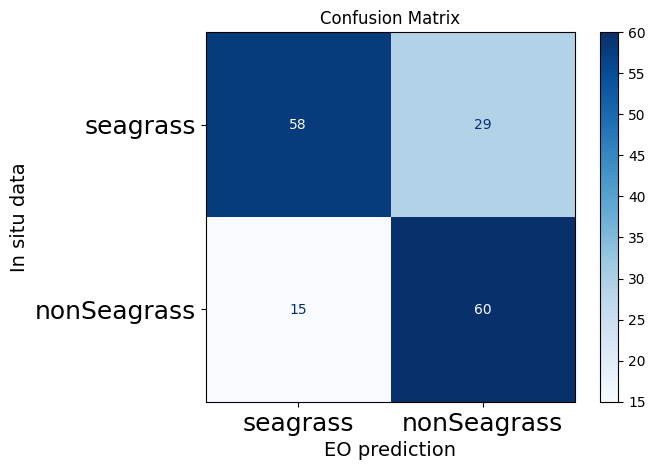

Overall Accuracy: 0.7283950617283951


PA: [0.6666666666666666, 0.8]
UA: [0.7945205479452054, 0.6741573033707865]
F1-score: 0.725


In [49]:
errorMatrix = sampledValidation_pre.errorMatrix('habitat', 'classification')
print('Confusion Matrix:', errorMatrix.getInfo())

# Get confusion matrix data as a list of lists
confusion_matrix_data = errorMatrix.array().getInfo()

# Convert the list to a NumPy array
matrix_values = np.array(confusion_matrix_data)  # Convert to NumPy array

# Define class labels
class_names = ['seagrass', 'nonSeagrass']  # Adjust if your class names are different

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_values, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel("EO prediction", fontsize = 14)  # Change to your desired text
plt.ylabel("In situ data", fontsize = 14)
disp.ax_.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick label size  # Change to your desired text
plt.show()

# Print accuracy metrics
overall_accuracy = errorMatrix.accuracy().getInfo()
print('Overall Accuracy:', overall_accuracy)
producers_accuracy = ee.Array(errorMatrix.producersAccuracy()).reshape([-1]).getInfo()
print('PA:', producers_accuracy)
users_accuracy = ee.Array(errorMatrix.consumersAccuracy()).reshape([-1]).getInfo()
print('UA:', users_accuracy)

# Calcuate F1-score
# Extract the components from the confusion matrix
truePositives = errorMatrix.array().get([0, 0])
falsePositives = errorMatrix.array().get([1, 0])
falseNegatives = errorMatrix.array().get([0, 1])

# Calculate precision, recall, and F1-score
precision = truePositives.divide(truePositives.add(falsePositives))
recall = truePositives.divide(truePositives.add(falseNegatives))
f1_score = ee.Number(2).multiply(precision.multiply(recall)).divide(precision.add(recall))

print('F1-score:', f1_score.getInfo())

### Area quantification stats and +-

In [55]:
# Mask seagrass pixels
seagrass_pre = final_classification_pre.eq(0)

# create a binary mask: 1 = seagrass, 0 = not
seagrass_mask = seagrass_pre.rename('seagrass')  # change eq(0) if your seagrass label differs

# count seagrass pixels (sum of 1s)
pixel_count = seagrass_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=10, # 10 m pixels
    maxPixels=1e13
).get('seagrass').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_pre = pixel_count * 100.0 / 10000.0

print(f"Seagrass pixels: {pixel_count}, area: {area_ha_pre} ha")

Seagrass pixels: 19033.666666666657, area: 190.33666666666656 ha


In [56]:
# Scale probabilities from 0-100 to 0-1
probabilities_pre = probabilities.map(lambda image: image.divide(100))

# Sum the seagrass probabilities for pre-event images
sum_seagrass_probabilities_pre = probabilities_pre.select('seagrass').sum()
sum_seagrass_probabilities_pre

# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_pre = sum_seagrass_probabilities_pre.updateMask(seagrass_mask).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=3, # Use the same scale as classification
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_pre = ee.Number(mean_sum_prob_seagrass_pre)

# Get the overall accuracy from the pre-event validation (assuming it's stored in overall_accuracy variable)
# If overall_accuracy is not the pre-event accuracy, you might need to re-calculate or use a stored value.
# Assuming 'overall_accuracy' currently holds the pre-event overall accuracy from cell j3bbR77kcVHf
overall_accuracy_pre = ee.Number(overall_accuracy) # Use the overall_accuracy from the pre-event validation cell

# Get the total seagrass area for the pre-event classification (assuming it's stored in area_ha variable from cell ZfHt_UQ49oKf)
# If not, you might need to recalculate it here or fetch it from the appropriate variable.
# Assuming 'area_ha' holds the pre-event seagrass area from cell ZfHt_UQ49oKf
total_seagrass_area_pre = ee.Number(area_ha_pre)


# Calculate uncertainty for the pre-event seagrass area using the provided formula:
# uncertainty = area * Overall Accuracy * (3 - mean of the sum of the probabilities predicted as seagrass) / 3
# Assuming '3' is the number of images used in the pre-event period (sentinel2_l1c_pre has 3 images)
num_images_pre = ee.Number(sentinel2_l1c_pre.size()) # Get the actual number of pre-event images

uncertainty_pre_seagrass_area = total_seagrass_area_pre.multiply(overall_accuracy_pre).multiply(num_images_pre.subtract(mean_sum_prob_seagrass_pre)).divide(num_images_pre)

print(f"Uncertainty of pre-event seagrass area: {area_ha_pre} +- {uncertainty_pre_seagrass_area.getInfo():.2f} ha")

Uncertainty of pre-event seagrass area: 190.33666666666656 +- 51.41 ha


6.1.8 - Uncertainty analysis

In [51]:
# ## To run uncertainties in the first classification (pre-event, 2018)
# ## t=(9*OA*(3-median probabilities))/3
# # 9 = area of pixel in square meters (3x3)
# # 3 = number of images

# ## first scale probabilities to 0-1 values
# def scale_to_unit(image):
#     return image.divide(100).copyProperties(image, image.propertyNames())

# # Apply the scaling function to the collection
# probabilities_01 = probabilities.map(scale_to_unit)

# median_probability = probabilities_01.select('seagrass').median().rename('seagrass_median_prob')
# median_probability

# # Select the band containing median probability
# median_probability = median_probability.select('seagrass_median_prob')

# # Apply the formula:
# # uncertainty = (9 * overall_accuracy * (3 - median_probability)) / 3
# three = ee.Number(3)
# nine = ee.Number(9)
# oa = ee.Number(overall_accuracy)

# # Compute: (3 - median_prob)
# diff = ee.Image.constant().subtract(median_probability)

# # Continue: (9 * overall_accuracy * diff) / 3
# # uncertainty = (diff.multiply(oa).multiply(nine)).divide(three)
# uncertainty = diff.divide(oa)

# # Add the uncertainty as a new band
# uncertainty_pre = image.addBands(uncertainty.rename('uncertainty'))

# region = uncertainty_pre.geometry()
# # Calculate min and max of the uncertainty band
# stats = uncertainty_pre.select('uncertainty').reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=region,
#     scale=3,
#     maxPixels=1e9
# )

# # Get the results
# min_val = stats.get('uncertainty_min').getInfo()
# max_val = stats.get('uncertainty_max').getInfo()

# print('Uncertainty range:', min_val, 'to', max_val)


# # ###########################

# # Select the uncertainty band
# uncertainty_pre = uncertainty_pre.select('uncertainty')

# # Normalize to 0–1
# normalized_uncertainty = uncertainty.subtract(min_val).divide(max_val - min_val)

# # Add it back to the image
# overlap_mask = combined_classification_pre.mask().reduce(ee.Reducer.anyNonZero())
# uncertainty_pre_norm = image.addBands(normalized_uncertainty.rename('uncertainty_norm'))

# region = uncertainty_pre_norm.geometry()
# # Calculate min and max of the uncertainty band
# stats2 = uncertainty_pre_norm.select('uncertainty_norm').reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=region,
#     scale=3,
#     maxPixels=1e9
# )

# # Get the results
# min_val = stats2.get('uncertainty_norm_min').getInfo()
# max_val = stats2.get('uncertainty_norm_max').getInfo()

# print('Uncertainty range norm:', min_val, 'to', max_val)

# # Visualize the mean uncertainty layer
# # Define visualization parameters for the uncertainty band
# # You may need to adjust the min/max values based on your data range
# vis_params = {'bands': ['uncertainty_norm'], 'palette': ['#4d004b', '#4f004d', '#50014e', '#520150', '#540251', '#550253', '#570354', '#580356', '#5a0457', '#5c0459', '#5d055a', '#5f055c', '#61065d', '#62065f', '#640761', '#650762', '#670864', '#690865', '#6a0867', '#6c0968', '#6e096a', '#6f0a6b', '#710a6d', '#730b6e', '#740b70', '#760c71', '#770c73', '#790d75', '#7b0d76', '#7c0e78', '#7e0e79', '#800f7b', '#810f7c', '#81117d', '#81127e', '#82147f', '#821580', '#821781', '#821982', '#831a83', '#831c84', '#831d85', '#831f86', '#832088', '#842289', '#84248a', '#84258b', '#84278c', '#85288d', '#852a8e', '#852b8f', '#852d90', '#852f91', '#863092', '#863293', '#863394', '#863595', '#873696', '#873897', '#873a98', '#873b99', '#873d9a', '#883e9b', '#88409c', '#88419d', '#88439e', '#88449e', '#88459f', '#8947a0', '#8948a0', '#8949a1', '#894ba2', '#894ca2', '#894da3', '#894fa3', '#8950a4', '#8a51a5', '#8a52a5', '#8a54a6', '#8a55a7', '#8a56a7', '#8a58a8', '#8a59a8', '#8a5aa9', '#8b5caa', '#8b5daa', '#8b5eab', '#8b60ac', '#8b61ac', '#8b62ad', '#8b64ad', '#8b65ae', '#8c66af', '#8c68af', '#8c69b0', '#8c6ab1', '#8c6cb1', '#8c6db2', '#8c6eb3', '#8c70b3', '#8c71b4', '#8c72b5', '#8c74b5', '#8c75b6', '#8c76b7', '#8c78b7', '#8c79b8', '#8c7ab8', '#8c7cb9', '#8c7dba', '#8c7eba', '#8c80bb', '#8c81bc', '#8c82bc', '#8c84bd', '#8c85be', '#8c86be', '#8c88bf', '#8c89c0', '#8c8bc0', '#8c8cc1', '#8c8dc2', '#8c8fc2', '#8c90c3', '#8c91c4', '#8c93c4', '#8c94c5', '#8c95c6', '#8c97c6', '#8d98c7', '#8d99c8', '#8e9ac8', '#8f9bc9', '#8f9dc9', '#909eca', '#909fcb', '#91a0cb', '#91a1cc', '#92a3cd', '#92a4cd', '#93a5ce', '#94a6ce', '#94a7cf', '#95a8d0', '#95aad0', '#96abd1', '#96acd2', '#97add2', '#98aed3', '#98b0d3', '#99b1d4', '#99b2d5', '#9ab3d5', '#9ab4d6', '#9bb6d7', '#9cb7d7', '#9cb8d8', '#9db9d9', '#9dbad9', '#9ebcda', '#9fbcda', '#a0bddb', '#a1bedb', '#a2bfdb', '#a3bfdc', '#a4c0dc', '#a5c1dc', '#a6c2dd', '#a7c2dd', '#a8c3de', '#a9c4de', '#aac4de', '#abc5df', '#acc6df', '#adc7e0', '#aec7e0', '#afc8e0', '#b0c9e1', '#b1c9e1', '#b2cae1', '#b3cbe2', '#b4cce2', '#b5cce3', '#b6cde3', '#b7cee3', '#b9cee4', '#bacfe4', '#bbd0e4', '#bcd1e5', '#bdd1e5', '#bed2e6', '#bfd3e6', '#c0d4e6', '#c1d4e7', '#c2d5e7', '#c3d6e8', '#c4d7e8', '#c5d8e9', '#c6d8e9', '#c7d9e9', '#c8daea', '#c9dbea', '#cadbeb', '#cbdceb', '#ccddec', '#cddeec', '#cedfec', '#cfdfed', '#d0e0ed', '#d1e1ee', '#d2e2ee', '#d3e2ef', '#d4e3ef', '#d6e4f0', '#d7e5f0', '#d8e6f0', '#d9e6f1', '#dae7f1', '#dbe8f2', '#dce9f2', '#ddeaf3', '#deeaf3', '#dfebf4', '#e0ecf4', '#e1ecf4', '#e1edf5', '#e2edf5', '#e3eef5', '#e4eef5', '#e4eff6', '#e5eff6', '#e6f0f6', '#e6f0f7', '#e7f1f7', '#e8f1f7', '#e9f2f7', '#e9f2f8', '#eaf3f8', '#ebf3f8', '#ebf4f8', '#ecf4f9', '#edf5f9', '#eef5f9', '#eef6fa', '#eff6fa', '#f0f7fa', '#f1f7fa', '#f1f8fb', '#f2f8fb', '#f3f9fb', '#f3f9fc', '#f4fafc', '#f5fafc', '#f6fbfc', '#f6fbfd', '#f7fcfd'], 'min': 0, 'max': 1}
# Map = geemap.Map()
# Map.addLayer(uncertainty_pre_norm.select('uncertainty_norm'), vis_params, "Uncertainty Pre-event")
# Map.centerObject(OSW, 13)
# Map

In [52]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=uncertainty_pre_norm.toFloat(),
#     description='uncertainty_pre_norm',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

In [53]:
# ## Calculate uncertainty
# # probability IC: probabilities
# # classified IC: classification_images_pre
# # validation pre: v_FC

# def calculate_uncertainty(prob_image, classified_image, validation_fc):
#     # Get the probability bands from the probability image
#     probabilities_image = prob_image.select(['seagrass', 'nonSeagrass'])

#     # Sample the classified image with validation points
#     validated = classified_image.sampleRegions(
#         collection=validation_fc, # Using the provided validation FeatureCollection
#         properties=['habitat'], # Assuming 'habitat' is the class property in v_FC
#         scale=3,
#         geometries=True
#     )

#     # Calculate overall accuracy if there are enough validation points
#     overall_accuracy = ee.Algorithms.If(
#         validated.size().gt(1),
#         validated.errorMatrix('habitat', 'classification').accuracy(),
#         ee.Number(1.0) # Default accuracy if not enough points
#     )

#     # Ensure overall_accuracy is treated as an Earth Engine Number
#     overall_accuracy = ee.Number(overall_accuracy)

#     # Calculate uncertainty per pixel: (1 - Probability of Seagrass) / Overall Accuracy
#     # Ensure overall_accuracy is treated as a constant image for pixel-wise division
#     overall_accuracy_image = ee.Image.constant(overall_accuracy).float()

#     # Calculate the uncertainty based on seagrass probability
#     # Lower probability of seagrass indicates higher uncertainty for seagrass class
#     # A common approach is 1 - probability or using entropy. Let's use 1 - probability as a simple measure.
#     uncertainty_prob = probabilities_image.select('seagrass').multiply(-1).add(1).rename('uncertainty_prob')

#     # You could also consider scaling by accuracy, e.g., uncertainty_prob / overall_accuracy
#     uncertainty = uncertainty_prob.divide(overall_accuracy_image).rename('uncertainty')

#     # Return the uncertainty band, aligning it with the classified image properties
#     return classified_image.addBands(uncertainty).copyProperties(classified_image, classified_image.propertyNames())


# # Apply the function to your ImageCollections
# # We need to iterate through one collection (e.g., classification_images_pre) and find the corresponding image in the other (probabilities)
# def map_uncertainty_calculation(classified_image):
#     # Find the corresponding probability image using the system:index
#     prob_image = probabilities.filter(ee.Filter.eq('system:index', classified_image.get('system:index'))).first()

#     # Calculate uncertainty for this image pair
#     return calculate_uncertainty(prob_image, classified_image, v_FC)


# # Assuming 'classification_images_pre' is your pre-event ImageCollection containing the 'classification' band
# # Assuming 'probabilities' is your pre-event ImageCollection containing 'seagrass' and 'nonSeagrass' bands
# # Assuming 'v_FC' is your FeatureCollection of validation points (pre-event validation data)

# uncertainty_images_pre = soft_map.map(map_uncertainty_calculation())

# # You can now visualize or export the 'uncertainty' band from the uncertainty_images_pre collection
# print('Uncertainty calculation added to pre-event images.')

# # uncertainty_images_pre_mean = uncertainty_images_pre.mean()
# # uncertainty_images_pre_mean

# uncertainty_images_pre

In [54]:
# # Display the combined classification
# Map.addLayer(uncertainty_images_pre.first().select('uncertainty'), {'min': 0, 'max': 1, 'palette': ['42762f', '7cb75a', 'e2e9ab', 'ffffff']}, 'Uncertainty')
# Map

## 6.2 - Post-event Multi-sensor Image Collection

In [57]:
# Binary classification setup
seagrass_class = 0
nonSeagrass_class = 1

# Classification and validation parameters
trees = 50
t = 45

# Boxcar kernel: a square matrix where all values are equal, and it calculates the mean of the pixel values within that square neighborhood.
boxcar = ee.Kernel.square(radius=2, units='pixels', normalize=True)
bands = multi_sensor_post.first().bandNames()
# print(bands.getInfo())

def boxcar_image(image):
    return image.convolve(boxcar)

# Apply the function to every image in the collection
classificationComp_post = multi_sensor_post.map(boxcar_image)
classificationComp_post

Output hidden; open in https://colab.research.google.com to view.

#### 6.2.1 - Prepare training dataset

In [58]:
# Training data - class property recoding and merging - MODEL 2 (POST-EVENT)
t_seagrass = t_seagrass_post.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [seagrass_class])))
t_nonSeagrass = t_nonSeagrass_post.map(lambda x: x.setMulti(ee.Dictionary.fromLists(['habitat'], [nonSeagrass_class])))
t_FC = t_seagrass.merge(t_nonSeagrass)


# Collect sampled features from each image
def sample_image(image):
    sampled = image.sampleRegions(
        collection=t_FC,
        scale=3,
        geometries=True
    ).filter(ee.Filter.notNull(bands))

    return sampled

# Map the sampling function and convert result to a list of FeatureCollections
sampled_fc_list = classificationComp_post.map(sample_image).toList(classificationComp_post.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledData = ee.FeatureCollection(sampled_fc_list).flatten()

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
# print('sampledData:', sampledData.size().getInfo())
print('t_FC:', t_FC.size().getInfo())

print('Size of t_seagrass_post:', t_seagrass_post.size().getInfo())
print('Size of t_nonSeagrass_post:', t_nonSeagrass_post.size().getInfo())

t_FC: 89
Size of t_seagrass_post: 42
Size of t_nonSeagrass_post: 47


#### 6.2.2 - Extract probabilities for each class and train classifier

{'S2_B1': 16.23520730587443, 'S2_B1B2': 20.746353799707556, 'S2_B2': 17.591714277102735, 'S2_B2B3': 13.458029566678812, 'S2_B3': 20.389727150480166, 'S2_B4': 19.14908794188344, 'S2_B5': 18.835177185684092, 'S2_B6': 18.314471459874845, 'S2_B7': 16.68099123740064, 'S2_B8': 20.1120486828127, 'S2_DII': 16.60051830298028, 'S2_SPM_Nechad2016_665': 17.19201512751657, 'S2_chl_re_mishra': 16.00013622249388}


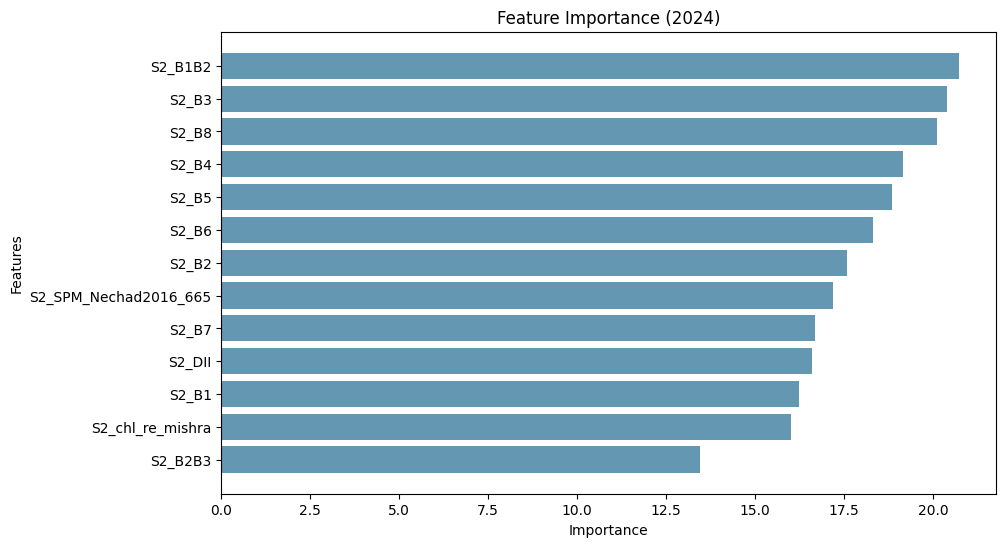

Selected bands: ['S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


<Figure size 640x480 with 0 Axes>

In [59]:
## To extract feature importance and evaluate
def soft_prob_subfn(image, num):
       training = sampledData.map(lambda ft: ft.set(
        'prob',
        ee.Algorithms.If(ft.getNumber('habitat').eq(num), 1, 0)
        ))

       trained = ee.Classifier.smileRandomForest(numberOfTrees=trees) \
           .train(training, 'prob', image.bandNames()) \
           .setOutputMode('PROBABILITY')

       dict_classifier = trained.explain()

       # Create a Feature with the dictionary as a property
       feature = ee.Feature(None, {'classifier_explanation': dict_classifier})

       # Classify and convert to percentage scale
       classified = image.classify(trained).multiply(100).toInt8()

       # Return both the classified image and the Feature with explanation
       return ee.Image(classified).set('classifier_explanation', feature)

# Map the function to your ImageCollection
seagrass_prob_IC = classificationComp_post.map(lambda img: soft_prob_subfn(img, seagrass_class))
nonSeagrass_prob_IC = classificationComp_post.map(lambda img: soft_prob_subfn(img, nonSeagrass_class))

### MEAN FEATURE IMPORTANCE
# Get the first three images from the ImageCollection
first_three_images = seagrass_prob_IC.toList(3)

# Initialize an empty dictionary to store feature importances
mean_importance = {}

# Iterate through the first three images
for i in range(3):
  image = ee.Image(first_three_images.get(i))
  classifier_explanation = image.get('classifier_explanation').getInfo()['properties']['classifier_explanation']
  importance_dict = classifier_explanation.get('importance')

  # Accumulate feature importances
  for feature, importance in importance_dict.items():
    mean_importance[feature] = mean_importance.get(feature, 0) + importance

# Calculate the mean feature importance
for feature in mean_importance:
  mean_importance[feature] /= 3

# Print the mean feature importance
print(mean_importance)

# Sort features by importance in descending order
sorted_importance = dict(sorted(mean_importance.items(), key=lambda item: item[1], reverse=False))

# Extract feature names and importance values
feature_names = list(sorted_importance.keys())
importance_values = list(sorted_importance.values())

# Create a list of colors based on feature name prefix
colors = ['#005b96' if name.startswith('PS_') else '#6497b1' for name in feature_names]

# Create the horizontal bar graph (switched axes)
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.barh(feature_names, importance_values, color=colors) # Changed to barh for horizontal bars
plt.ylabel("Features") # Switched x and y labels
plt.xlabel("Importance") # Switched x and y labels
plt.title("Feature Importance (2024)")
# plt.axvline(x=4.2, linestyle='dotted', color='grey')  # Add dotted vertical line
plt.show()  # Display the plot
plt.tight_layout()

selected_bands = [band for band, importance in mean_importance.items() if importance >= 0] ## Use only selected bands for the classification ##4.2 before

print("Selected bands:", selected_bands)

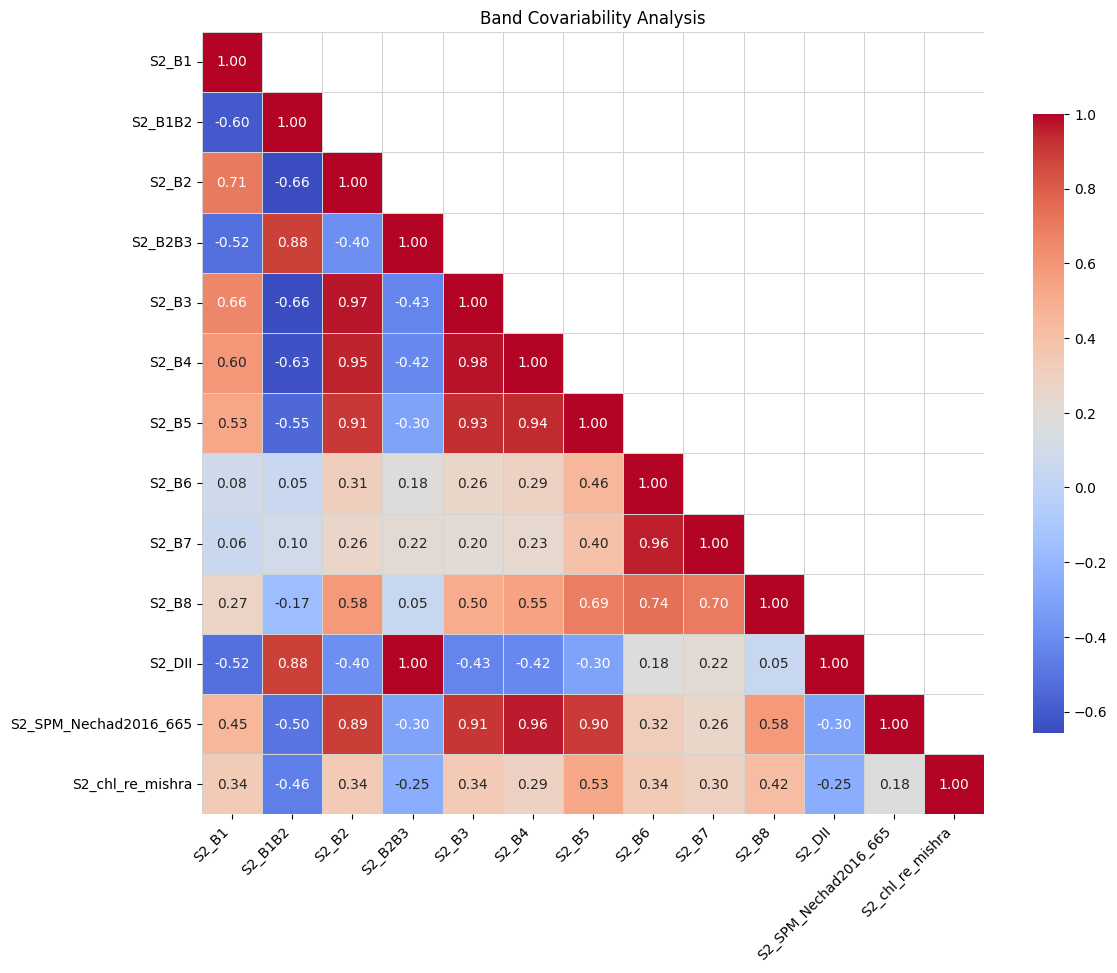

Bands to keep: ['S2_B1', 'S2_B1B2', 'S2_B2', 'S2_B2B3', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_DII', 'S2_SPM_Nechad2016_665', 'S2_chl_re_mishra']


In [60]:
## Co-variance analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to extract band values from a FeatureCollection
def extract_band_values(feature_collection, bands):
    data = feature_collection.toList(feature_collection.size()).map(lambda feature: ee.Feature(feature).toDictionary().select(bands)).getInfo()
    df = pd.DataFrame(data)
    return df

# Extract band values for selected bands
band_values_df = extract_band_values(sampledData, selected_bands)

# Calculate the correlation matrix
correlation_matrix = band_values_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, bool), k=1)

# Apply the mask to the filtered correlation matrix
filtered_correlation_matrix = correlation_matrix.mask(mask)
filtered_correlation_matrix = filtered_correlation_matrix[np.abs(correlation_matrix) > 0.80]

# Get bands with at least one correlation above 0.9
bands_to_keep = filtered_correlation_matrix.columns[filtered_correlation_matrix.any()]

# Filter the original correlation matrix to keep only relevant bands
filtered_correlation_matrix = correlation_matrix.loc[bands_to_keep, bands_to_keep]

# Plot only the lower triangle of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            fmt=".2f", linewidths=.5, linecolor='lightgrey', square=True,
            cbar_kws={"shrink": .75})
plt.title('Band Covariability Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Bands to keep:", bands_to_keep.tolist())

In [61]:
# #### REMOVE BANDS THAT ARE NOT USEFUL

# # Define the bands to remove
# bands_to_remove = ['PS_B8', 'S2_B8', 'S2_B6'] # 'PS_Kd_505', 'S2_B6', 'S2_B7', 'S2_B8',

# # Create a list of bands to keep by filtering out the bands to remove
# selected_bands = [band for band in selected_bands if band not in bands_to_remove]

# # Apply the select method to the Image Collection to keep the desired bands
# classificationComp_post = classificationComp_post.select(selected_bands)
# classificationComp_post.first().bandNames()
# classificationComp_post

### 6.2.3 - Generate probability layers

In [62]:
## Train classifier and display probability map for seagrasses
# Define classes dictionary
classes = {
  'classes_values': [seagrass_class, nonSeagrass_class],
  'classes_names': ['seagrass','nonSeagrass']
}

classes

# Assume this is already defined:
# - classificationComp_pre: an ImageCollection
# - classes: dictionary with class values and names
# - soft_prob_subfn(image, class_id): returns a probability image for one class

def classify_with_all_classes(image):
    # Classify image for each class and rename the result accordingly
    classified_images = ee.List(classes['classes_values']).map(
        lambda class_id: soft_prob_subfn(image, class_id)
    )

    # Convert list of images into one multi-band image (each class as band)
    classified_combined = ee.ImageCollection(classified_images).toBands()
    classified_combined = classified_combined.rename(classes['classes_names'])

    # Preserve metadata if needed
    return classified_combined.copyProperties(image, image.propertyNames())

# Generate probabilities in the ImageCollection
probabilities = classificationComp_post.map(classify_with_all_classes)
probabilities

Output hidden; open in https://colab.research.google.com to view.

In [63]:
# Visualize probabilities
first_prob = ee.Image(probabilities.toList(probabilities.size()).get(0))
Map = geemap.Map()
Map.addLayer(first_prob.select('seagrass'), {'min': 45, 'max': 100}, 'Seagrass Prob')
Map.addLayer(first_prob.select('nonSeagrass'), {'min': 45, 'max': 100}, 'NonSeagrass Prob')
Map.centerObject(probabilities.first(), zoom=12)
Map

Map(center=[-27.57434177193234, -48.45318139273372], controls=(WidgetControl(options=['position', 'transparent…

#### 6.2.4 - Threshold classes based on probabilities and classify

In [64]:
# Based on the generated probabilities, apply thresholding for seagrass and nonSeagrass on the whole Image Collection

# Threshold function for seagrass
def threshold_seagrass(image):
    return image.select('seagrass').updateMask(image.select('seagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Threshold function for non-seagrass
def threshold_non_seagrass(image):
    return image.select('nonSeagrass').updateMask(image.select('nonSeagrass').gt(t)) \
        .copyProperties(image, image.propertyNames())

# Map the thresholding over the probabilities collection
seagrass_soft = probabilities.map(threshold_seagrass)
nonSeagrass_soft = probabilities.map(threshold_non_seagrass)
nonSeagrass_soft

# Function to combine seagrass and nonSeagrass into one image
def add_bands(image):
    matching_non_seagrass = nonSeagrass_soft.filter(
        ee.Filter.eq('system:index', image.get('system:index'))
    ).first()

    # If no match is found, return image as-is
    combined = ee.Image(image).addBands(ee.Image(matching_non_seagrass))
    return combined.copyProperties(image, image.propertyNames())

# Map the function to seagrass_soft collection to create the aggregated collection
soft_map = seagrass_soft.map(add_bands)
soft_map

Output hidden; open in https://colab.research.google.com to view.

#### 6.2.5 - Perform classification

In [65]:
def soft_to_hard(image):
    seagrass = image.select('seagrass')
    non_seagrass = image.select('nonSeagrass')
    prob_aoi = ee.Image(probabilities.first()).geometry()

    # Get the corresponding images from seagrass_soft and nonSeagrass_soft using system:index
    seagrass_soft_image = seagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()
    nonSeagrass_soft_image = nonSeagrass_soft.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()

    classified = (ee.Image.constant(2)
        .where(seagrass.gte(t), ee.Number(0).add(1))  # temporary +1 to mask 0s
        .where(non_seagrass.gte(t), ee.Number(1).add(1))
        .selfMask()
        .subtract(1)  # back to 0 and 1
        .rename('classification')
        .clip(prob_aoi))

    return classified.copyProperties(image, image.propertyNames())

# Apply to soft_map
soft_map_th = soft_map.map(soft_to_hard)
soft_map_th

Output hidden; open in https://colab.research.google.com to view.

#### 6.2.6 - Combine the three classifications for visualization

In [66]:
# 1. Extract the 'classification' band from each image
classification_images_post = soft_map_th.select('classification')

# 2. Calculate the mean value
combined_classification_post = classification_images_post.mean().mask(land_mask).clip(OSW) #.selfMask()
# print(combined_classification.getInfo())

## Display the combined classification
Map.addLayer(combined_classification_post, {'min': 0, 'max': 1, 'palette': ['42762f', '7cb75a', 'e2e9ab', 'ffffff']}, 'Combined Classification')
Map

Map(center=[-27.57434177193234, -48.45318139273372], controls=(WidgetControl(options=['position', 'transparent…

In [67]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=combined_classification_post,
#     description='combined_classification_post',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

In [68]:
# Apply conditional classification for obtain the final binary map
final_classification_post = combined_classification_post.expression(
    'b(0) < 0.35 ? 0 : 1',  # Conditional expression
    {'classification': combined_classification_post}  # Band name mapping
).rename('classification')  # Rename the band

# Display the combined classification
Map.addLayer(final_classification_post.mask(land_mask).clip(OSW.geometry()), {'min': 0, 'max': 1, 'palette': ['42762f', 'ffffff']}, 'Combined Classification')
Map

Map(center=[-27.57434177193234, -48.45318139273372], controls=(WidgetControl(options=['position', 'transparent…

In [69]:
final_classification_post

#### 6.2.7 - Validation and accuracy assessment for each of the 3 classifications

In [70]:
# Validation function
def valid_habitat(number):
  def wrap(feature):
    return feature.setMulti(ee.Dictionary.fromLists(['habitat'], [number]))
  return wrap

## Validation data
v_seagrass = v_seagrass_post.map(valid_habitat(seagrass_class))
v_nonSeagrass = v_nonSeagrass_post.map(valid_habitat(nonSeagrass_class))
v_FC = v_seagrass.merge(v_nonSeagrass)
v_FC

In [71]:
## To validate with the final combination of the 3 classifications (this will be better)
# sampledValidation_post = final_classification_post.sampleRegions(
#     collection=v_FC,
#     scale=3,
#     properties=['habitat'])

# sampledValidation_post

In [72]:
# Collect sampled features from each image
# buffered_v_FC = v_FC.map(lambda feature: feature.buffer(5))

def validation(image):
    sampled = image.sampleRegions(
        collection=v_FC,
        properties=['habitat'],
        scale=3)
    return sampled

# Map the sampling function and convert result to a list of FeatureCollections
sampled_v_list = soft_map_th.map(validation).toList(soft_map_th.size())

# Flatten the FeatureCollections into one big FeatureCollection
sampledValidation_post = ee.FeatureCollection(sampled_v_list).flatten()

# ## To validate with the final combination of the 3 classifications (this will be better)
# sampledValidation_post = final_classification_post.sampleRegions(
#     collection=v_FC,
#     scale=3,
#     properties=['habitat'])

# Using sampleRegions we take values across the Image Collection. getting valid FeatureCollection when overlapping with pixels
print('sampled Validation:', sampledValidation_post.size().getInfo())
sampledValidation_post

sampled Validation: 90


Confusion Matrix: [[19, 32], [1, 38]]


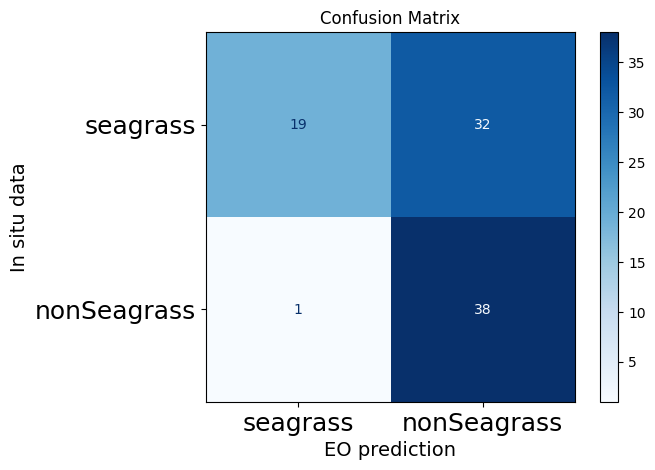

Overall Accuracy: 0.6333333333333333
PA: [0.37254901960784315, 0.9743589743589743]
UA: [0.95, 0.5428571428571428]
F1-score: 0.5352112676056339


In [73]:
errorMatrix = sampledValidation_post.errorMatrix('habitat', 'classification')
print('Confusion Matrix:', errorMatrix.getInfo())

# Get confusion matrix data as a list of lists
confusion_matrix_data = errorMatrix.array().getInfo()

# Convert the list to a NumPy array
matrix_values = np.array(confusion_matrix_data)  # Convert to NumPy array

# Define class labels
class_names = ['seagrass', 'nonSeagrass']  # Adjust if your class names are different

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_values, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel("EO prediction", fontsize = 14)  # Change to your desired text
plt.ylabel("In situ data", fontsize = 14)
disp.ax_.tick_params(axis='both', which='major', labelsize=18)  # Increase axis tick label size  # Change to your desired text
plt.show()

# Print accuracy metrics
overall_accuracy = errorMatrix.accuracy().getInfo()
print('Overall Accuracy:', overall_accuracy)
producers_accuracy = ee.Array(errorMatrix.producersAccuracy()).reshape([-1]).getInfo()
print('PA:', producers_accuracy)
users_accuracy = ee.Array(errorMatrix.consumersAccuracy()).reshape([-1]).getInfo()
print('UA:', users_accuracy)

# Calcuate F1-score
# Extract the components from the confusion matrix
truePositives = errorMatrix.array().get([0, 0])
falsePositives = errorMatrix.array().get([1, 0])
falseNegatives = errorMatrix.array().get([0, 1])

# Calculate precision, recall, and F1-score
precision = truePositives.divide(truePositives.add(falsePositives))
recall = truePositives.divide(truePositives.add(falseNegatives))
f1_score = ee.Number(2).multiply(precision.multiply(recall)).divide(precision.add(recall))

print('F1-score:', f1_score.getInfo())

In [74]:
## Calculate hectares pre
seagrass_pre = final_classification_pre.select('classification').eq(0)

# Reducir para contar píxeles dentro del ROI
pixel_stats = seagrass_pre.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW,
    scale=10,
    maxPixels=1e13
)

# Calcular hectáreas (cada píxel = 0.01 ha)
pixel_count = ee.Number(pixel_stats.get('classification'))
hectareas = pixel_count.multiply(0.01)

print("Área de praderas (hectáreas):", hectareas.getInfo())

Área de praderas (hectáreas): 190.33666666666656


In [75]:
## Calculate hectares post
seagrass_post = final_classification_post.select('classification').eq(0)

# Reducir para contar píxeles dentro del ROI
pixel_stats = seagrass_post.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW,
    scale=10,
    maxPixels=1e13
)

# Calcular hectáreas (cada píxel = 0.01 ha)
pixel_count = ee.Number(pixel_stats.get('classification'))
hectareas = pixel_count.multiply(0.01)

print("Área de praderas (hectáreas):", hectareas.getInfo())

Área de praderas (hectáreas): 44.739137254901905


### Area quantification stats and +-

In [76]:
# Mask seagrass pixels
seagrass_post = final_classification_post.eq(0)

# create a binary mask: 1 = seagrass, 0 = not
seagrass_mask = seagrass_post.rename('seagrass')  # change eq(0) if your seagrass label differs

# count seagrass pixels (sum of 1s)
pixel_count = seagrass_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=OSW.geometry(),
    scale=10, # 10 m pixels
    maxPixels=1e13
).get('seagrass').getInfo()

# convert to hectares: each pixel = 9 m2 -> 9/10000 = 0.0009 ha
area_ha_post = pixel_count * 100.0 / 10000.0

print(f"Seagrass pixels: {pixel_count}, area: {area_ha_post} ha")

Seagrass pixels: 4473.913725490191, area: 44.739137254901905 ha


In [79]:
# Scale probabilities from 0-100 to 0-1
probabilities_post = probabilities.map(lambda image: image.divide(100))

# Sum the seagrass probabilities for pre-event images
sum_seagrass_probabilities_post = probabilities_post.select('seagrass').sum()
sum_seagrass_probabilities_post

# Calculate the mean of the summed probabilities within the seagrass mask
mean_sum_prob_seagrass_post = sum_seagrass_probabilities_post.updateMask(seagrass_mask).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=OSW.geometry(),
    scale=10,
    maxPixels=1e13
).get('seagrass')

mean_sum_prob_seagrass_post = ee.Number(mean_sum_prob_seagrass_post)

overall_accuracy_post = ee.Number(overall_accuracy) # Use the overall_accuracy from the pre-event validation cell

# Get the total seagrass area for the pre-event classification (assuming it's stored in area_ha variable from cell ZfHt_UQ49oKf)
# If not, you might need to recalculate it here or fetch it from the appropriate variable.
total_seagrass_area_post = ee.Number(area_ha_post)


# Calculate uncertainty for the pre-event seagrass area using the provided formula:
# uncertainty = area * Overall Accuracy * (3 - mean of the sum of the probabilities predicted as seagrass) / 3
# Assuming '3' is the number of images used in the pre-event period (sentinel2_l1c_pre has 3 images)
num_images_post = ee.Number(sentinel2_l1c_post.size()) # Get the actual number of pre-event images

uncertainty_post_seagrass_area = total_seagrass_area_post.multiply(overall_accuracy_post).multiply(num_images_post.subtract(mean_sum_prob_seagrass_post)).divide(num_images_post)

print(f"Uncertainty of post-event seagrass area: {area_ha_post} +- {uncertainty_post_seagrass_area.getInfo():.2f} ha")

Uncertainty of post-event seagrass area: 44.739137254901905 +- 10.29 ha


#### 6.1.8 - Uncertainty analysis

In [77]:
# ## To run uncertainties in the first classification (pre-event, 2018)
# ## t=(9*OA*(3-median probabilities))/3
# # 9 = area of pixel in square meters (3x3)
# # 3 = number of images

# ## first scale probabilities to 0-1 values
# def scale_to_unit(image):
#     return image.divide(100).copyProperties(image, image.propertyNames())

# # Apply the scaling function to the collection
# probabilities_01 = probabilities.map(scale_to_unit)

# median_probability = probabilities_01.select('seagrass').median().rename('seagrass_median_prob')
# median_probability

# # Select the band containing median probability
# median_probability = median_probability.select('seagrass_median_prob')

# # Apply the formula:
# # uncertainty = (9 * overall_accuracy * (3 - median_probability)) / 3
# three = ee.Number(3)
# nine = ee.Number(9)
# oa = ee.Number(overall_accuracy)

# # Compute: (3 - median_prob)
# diff = ee.Image.constant(1).subtract(median_probability)

# # Continue: (9 * overall_accuracy * diff) / 3
# # uncertainty = (diff.multiply(oa).multiply(nine)).divide(three)
# uncertainty = diff.divide(oa)

# # Add the uncertainty as a new band
# uncertainty_post = image.addBands(uncertainty.rename('uncertainty'))

# region = uncertainty_post.geometry()
# # Calculate min and max of the uncertainty band
# stats = uncertainty_post.select('uncertainty').reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=region,
#     scale=3,
#     maxPixels=1e9
# )

# # Get the results
# min_val = stats.get('uncertainty_min').getInfo()
# max_val = stats.get('uncertainty_max').getInfo()

# print('Uncertainty range:', min_val, 'to', max_val)


# # ###########################

# # Select the uncertainty band
# uncertainty_post = uncertainty_post.select('uncertainty')

# # Normalize to 0–1
# normalized_uncertainty = uncertainty_post.subtract(min_val).divide(max_val - min_val)

# # Add it back to the image
# overlap_mask = combined_classification_post.mask().reduce(ee.Reducer.anyNonZero())
# uncertainty_post_norm = image.addBands(normalized_uncertainty.rename('uncertainty_norm'))

# region = uncertainty_pre_norm.geometry()
# # Calculate min and max of the uncertainty band
# stats2 = uncertainty_post_norm.select('uncertainty_norm').reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=region,
#     scale=3,
#     maxPixels=1e9
# )

# # Get the results
# min_val = stats2.get('uncertainty_norm_min').getInfo()
# max_val = stats2.get('uncertainty_norm_max').getInfo()

# print('Uncertainty range norm:', min_val, 'to', max_val)

# # Visualize the mean uncertainty layer
# # Define visualization parameters for the uncertainty band
# # You may need to adjust the min/max values based on your data range
# vis_params = {'bands': ['uncertainty_norm'], 'palette': ['#4d004b', '#4f004d', '#50014e', '#520150', '#540251', '#550253', '#570354', '#580356', '#5a0457', '#5c0459', '#5d055a', '#5f055c', '#61065d', '#62065f', '#640761', '#650762', '#670864', '#690865', '#6a0867', '#6c0968', '#6e096a', '#6f0a6b', '#710a6d', '#730b6e', '#740b70', '#760c71', '#770c73', '#790d75', '#7b0d76', '#7c0e78', '#7e0e79', '#800f7b', '#810f7c', '#81117d', '#81127e', '#82147f', '#821580', '#821781', '#821982', '#831a83', '#831c84', '#831d85', '#831f86', '#832088', '#842289', '#84248a', '#84258b', '#84278c', '#85288d', '#852a8e', '#852b8f', '#852d90', '#852f91', '#863092', '#863293', '#863394', '#863595', '#873696', '#873897', '#873a98', '#873b99', '#873d9a', '#883e9b', '#88409c', '#88419d', '#88439e', '#88449e', '#88459f', '#8947a0', '#8948a0', '#8949a1', '#894ba2', '#894ca2', '#894da3', '#894fa3', '#8950a4', '#8a51a5', '#8a52a5', '#8a54a6', '#8a55a7', '#8a56a7', '#8a58a8', '#8a59a8', '#8a5aa9', '#8b5caa', '#8b5daa', '#8b5eab', '#8b60ac', '#8b61ac', '#8b62ad', '#8b64ad', '#8b65ae', '#8c66af', '#8c68af', '#8c69b0', '#8c6ab1', '#8c6cb1', '#8c6db2', '#8c6eb3', '#8c70b3', '#8c71b4', '#8c72b5', '#8c74b5', '#8c75b6', '#8c76b7', '#8c78b7', '#8c79b8', '#8c7ab8', '#8c7cb9', '#8c7dba', '#8c7eba', '#8c80bb', '#8c81bc', '#8c82bc', '#8c84bd', '#8c85be', '#8c86be', '#8c88bf', '#8c89c0', '#8c8bc0', '#8c8cc1', '#8c8dc2', '#8c8fc2', '#8c90c3', '#8c91c4', '#8c93c4', '#8c94c5', '#8c95c6', '#8c97c6', '#8d98c7', '#8d99c8', '#8e9ac8', '#8f9bc9', '#8f9dc9', '#909eca', '#909fcb', '#91a0cb', '#91a1cc', '#92a3cd', '#92a4cd', '#93a5ce', '#94a6ce', '#94a7cf', '#95a8d0', '#95aad0', '#96abd1', '#96acd2', '#97add2', '#98aed3', '#98b0d3', '#99b1d4', '#99b2d5', '#9ab3d5', '#9ab4d6', '#9bb6d7', '#9cb7d7', '#9cb8d8', '#9db9d9', '#9dbad9', '#9ebcda', '#9fbcda', '#a0bddb', '#a1bedb', '#a2bfdb', '#a3bfdc', '#a4c0dc', '#a5c1dc', '#a6c2dd', '#a7c2dd', '#a8c3de', '#a9c4de', '#aac4de', '#abc5df', '#acc6df', '#adc7e0', '#aec7e0', '#afc8e0', '#b0c9e1', '#b1c9e1', '#b2cae1', '#b3cbe2', '#b4cce2', '#b5cce3', '#b6cde3', '#b7cee3', '#b9cee4', '#bacfe4', '#bbd0e4', '#bcd1e5', '#bdd1e5', '#bed2e6', '#bfd3e6', '#c0d4e6', '#c1d4e7', '#c2d5e7', '#c3d6e8', '#c4d7e8', '#c5d8e9', '#c6d8e9', '#c7d9e9', '#c8daea', '#c9dbea', '#cadbeb', '#cbdceb', '#ccddec', '#cddeec', '#cedfec', '#cfdfed', '#d0e0ed', '#d1e1ee', '#d2e2ee', '#d3e2ef', '#d4e3ef', '#d6e4f0', '#d7e5f0', '#d8e6f0', '#d9e6f1', '#dae7f1', '#dbe8f2', '#dce9f2', '#ddeaf3', '#deeaf3', '#dfebf4', '#e0ecf4', '#e1ecf4', '#e1edf5', '#e2edf5', '#e3eef5', '#e4eef5', '#e4eff6', '#e5eff6', '#e6f0f6', '#e6f0f7', '#e7f1f7', '#e8f1f7', '#e9f2f7', '#e9f2f8', '#eaf3f8', '#ebf3f8', '#ebf4f8', '#ecf4f9', '#edf5f9', '#eef5f9', '#eef6fa', '#eff6fa', '#f0f7fa', '#f1f7fa', '#f1f8fb', '#f2f8fb', '#f3f9fb', '#f3f9fc', '#f4fafc', '#f5fafc', '#f6fbfc', '#f6fbfd', '#f7fcfd'], 'min': 0, 'max': 1}
# Map = geemap.Map()
# Map.addLayer(uncertainty_post_norm.select('uncertainty_norm'), vis_params, "Uncertainty Post-event")
# Map.centerObject(OSW, 13)
# Map

In [78]:
# # Export the FeatureCollection to Google Drive
# task = ee.batch.Export.image.toDrive(
#     image=uncertainty_post_norm.toFloat(),
#     description='uncertainty_post_norm',  # Description for the task
#     folder='Colab_Notebooks/export',
#     region = OSW.geometry(),
#     scale=3,  # Adjust the scale as needed
#     fileFormat='GeoTIFF'  # Choose your desired file format (CSV, GeoJSON, KML, SHP, TFRecord)
# )

# # Start the export task
# task.start()

# print('Export task started. You can monitor its progress in the "Tasks" tab.')

# 7 - Seagrass change detection

In [ ]:
seagrass_pre = final_classification_pre.updateMask(final_classification_pre.select('classification').eq(0))
seagrass_post = final_classification_post.updateMask(final_classification_post.select('classification').eq(0))

seagrass_pre

In [ ]:
# Change from 0 to 1 (e.g., newly appeared features)
gain = final_classification_pre.eq(1).And(final_classification_post.eq(0))

# Change from 1 to 0 (e.g., disappeared features)
loss = final_classification_pre.eq(0).And(final_classification_post.eq(1))

# Stable seagrass meadows
stable = final_classification_pre.eq(0).And(final_classification_post.eq(0))

# Combine the conditions into a single image using 'where'
seagrass_change = ee.Image(0) \
    .where(loss, 1) \
    .where(stable, 2) \
    .where(gain, 3)

seagrass_change

In [ ]:
# Display the combined classification
seagrass_change = seagrass_change.updateMask(land_mask).clip(OSW).selfMask()
Map.addLayer(seagrass_change, {'min': 1, 'max': 3, 'palette': ['df8556', '42762f', '67688f']}, 'Combined Classification')
Map

Map(bottom=608182.0, center=[-27.569764850084354, -48.45434188842774], controls=(WidgetControl(options=['posit…

In [ ]:
# Define the export task
task = ee.batch.Export.image.toDrive(
    image=seagrass_change,
    description='seagrass_change',  # Description for the task
    folder='Colab_Notebooks/export',  # Folder in Google Drive to save the image (change if needed)
    fileNamePrefix='seagrass_change',  # Prefix for the file name
    region=roi,  # Region of interest (assuming 'roi' is defined)
    scale=3,  # Scale in meters (adjust if needed)
    fileFormat='GeoTIFF',  # File format
    maxPixels=1e13  # Maximum number of pixels allowed (adjust if needed)
)

# Start the export task
task.start()
print('Export task started. You can monitor its progress in the "Tasks" tab.')

Export task started. You can monitor its progress in the "Tasks" tab.


In [ ]:
# # Visualize desirable bands to check data
# s2_b8a_pre = multi_sensor_pre.first().select('S2_chl_re_mishra')

# # Define visualization parameters for S2_B8A
# # Adjust min/max values based on your data range
# s2_b8a_vis = {
#     'min': 0,
#     'max': 0.15,  # Example max value, adjust as needed
#     'palette': 'viridis' # Or any other suitable palette
# }

# Map.addLayer(s2_b8a_pre, s2_b8a_vis, "Sentinel-2 chla")
# Map

Map.addLayer(seagrass_samples_18, {'color': 'darkgreen'}, 'in situ seagrass 2018')
Map.addLayer(nonSeagrass_samples_18, {'color': 'orange'}, 'in situ nonSeagrass 2018')

Map.addLayer(sampledValidation_pre, {'color': 'pink'}, 'sampledValidation_pre')

Map.addLayer(seagrass_samples_24, {'color': 'lightgreen'}, 'in situ seagrass 2024')
Map.addLayer(nonSeagrass_samples_24, {'color': 'yellow'}, 'in situ nonSeagrass 2024')
Map

In [ ]:
# Select bands
pre = uncertainty_pre_norm.select('uncertainty_norm')
post = uncertainty_post_norm.select('uncertainty_norm')

# Root-sum-of-squares
uncertainty_change = pre.pow(2).add(post.pow(2)).sqrt().rename('uncertainty_change')

# Optionally normalize or add to a base image
result = image.addBands(uncertainty_change)
result

In [ ]:
region = OSW.geometry()
# Calculate min and max of the uncertainty band
stats2 = uncertainty_change.select('uncertainty_change').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=region,
    scale=3,
    maxPixels=1e9
)

# Get the results
min_val = stats2.get('uncertainty_change_min').getInfo()
max_val = stats2.get('uncertainty_change_max').getInfo()

print('Uncertainty range:', min_val, 'to', max_val)

# Select the uncertainty band
uncertainty_change = uncertainty_change.select('uncertainty_change')

# Normalize to 0–1
normalized_uncertainty = uncertainty_change.subtract(min_val).divide(max_val - min_val)

# Add it back to the image
overlap_mask = uncertainty_change.mask().reduce(ee.Reducer.anyNonZero())
uncertainty_change_norm = image.addBands(normalized_uncertainty.rename('uncertainty_change_norm'))

region = uncertainty_pre_norm.geometry()
# Calculate min and max of the uncertainty band
stats2 = uncertainty_post_norm.select('uncertainty_change_norm').reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=region,
    scale=3,
    maxPixels=1e9
)

# Get the results
min_val = stats2.get('uncertainty_change_norm_min').getInfo()
max_val = stats2.get('uncertainty_change_norm_max').getInfo()

print('Uncertainty range norm:', min_val, 'to', max_val)


# Visualize the mean uncertainty layer
# Define visualization parameters for the uncertainty band
# You may need to adjust the min/max values based on your data range
vis_params = {'bands': ['uncertainty_change_norm'], 'palette': ['#4d004b', '#4f004d', '#50014e', '#520150', '#540251', '#550253', '#570354', '#580356', '#5a0457', '#5c0459', '#5d055a', '#5f055c', '#61065d', '#62065f', '#640761', '#650762', '#670864', '#690865', '#6a0867', '#6c0968', '#6e096a', '#6f0a6b', '#710a6d', '#730b6e', '#740b70', '#760c71', '#770c73', '#790d75', '#7b0d76', '#7c0e78', '#7e0e79', '#800f7b', '#810f7c', '#81117d', '#81127e', '#82147f', '#821580', '#821781', '#821982', '#831a83', '#831c84', '#831d85', '#831f86', '#832088', '#842289', '#84248a', '#84258b', '#84278c', '#85288d', '#852a8e', '#852b8f', '#852d90', '#852f91', '#863092', '#863293', '#863394', '#863595', '#873696', '#873897', '#873a98', '#873b99', '#873d9a', '#883e9b', '#88409c', '#88419d', '#88439e', '#88449e', '#88459f', '#8947a0', '#8948a0', '#8949a1', '#894ba2', '#894ca2', '#894da3', '#894fa3', '#8950a4', '#8a51a5', '#8a52a5', '#8a54a6', '#8a55a7', '#8a56a7', '#8a58a8', '#8a59a8', '#8a5aa9', '#8b5caa', '#8b5daa', '#8b5eab', '#8b60ac', '#8b61ac', '#8b62ad', '#8b64ad', '#8b65ae', '#8c66af', '#8c68af', '#8c69b0', '#8c6ab1', '#8c6cb1', '#8c6db2', '#8c6eb3', '#8c70b3', '#8c71b4', '#8c72b5', '#8c74b5', '#8c75b6', '#8c76b7', '#8c78b7', '#8c79b8', '#8c7ab8', '#8c7cb9', '#8c7dba', '#8c7eba', '#8c80bb', '#8c81bc', '#8c82bc', '#8c84bd', '#8c85be', '#8c86be', '#8c88bf', '#8c89c0', '#8c8bc0', '#8c8cc1', '#8c8dc2', '#8c8fc2', '#8c90c3', '#8c91c4', '#8c93c4', '#8c94c5', '#8c95c6', '#8c97c6', '#8d98c7', '#8d99c8', '#8e9ac8', '#8f9bc9', '#8f9dc9', '#909eca', '#909fcb', '#91a0cb', '#91a1cc', '#92a3cd', '#92a4cd', '#93a5ce', '#94a6ce', '#94a7cf', '#95a8d0', '#95aad0', '#96abd1', '#96acd2', '#97add2', '#98aed3', '#98b0d3', '#99b1d4', '#99b2d5', '#9ab3d5', '#9ab4d6', '#9bb6d7', '#9cb7d7', '#9cb8d8', '#9db9d9', '#9dbad9', '#9ebcda', '#9fbcda', '#a0bddb', '#a1bedb', '#a2bfdb', '#a3bfdc', '#a4c0dc', '#a5c1dc', '#a6c2dd', '#a7c2dd', '#a8c3de', '#a9c4de', '#aac4de', '#abc5df', '#acc6df', '#adc7e0', '#aec7e0', '#afc8e0', '#b0c9e1', '#b1c9e1', '#b2cae1', '#b3cbe2', '#b4cce2', '#b5cce3', '#b6cde3', '#b7cee3', '#b9cee4', '#bacfe4', '#bbd0e4', '#bcd1e5', '#bdd1e5', '#bed2e6', '#bfd3e6', '#c0d4e6', '#c1d4e7', '#c2d5e7', '#c3d6e8', '#c4d7e8', '#c5d8e9', '#c6d8e9', '#c7d9e9', '#c8daea', '#c9dbea', '#cadbeb', '#cbdceb', '#ccddec', '#cddeec', '#cedfec', '#cfdfed', '#d0e0ed', '#d1e1ee', '#d2e2ee', '#d3e2ef', '#d4e3ef', '#d6e4f0', '#d7e5f0', '#d8e6f0', '#d9e6f1', '#dae7f1', '#dbe8f2', '#dce9f2', '#ddeaf3', '#deeaf3', '#dfebf4', '#e0ecf4', '#e1ecf4', '#e1edf5', '#e2edf5', '#e3eef5', '#e4eef5', '#e4eff6', '#e5eff6', '#e6f0f6', '#e6f0f7', '#e7f1f7', '#e8f1f7', '#e9f2f7', '#e9f2f8', '#eaf3f8', '#ebf3f8', '#ebf4f8', '#ecf4f9', '#edf5f9', '#eef5f9', '#eef6fa', '#eff6fa', '#f0f7fa', '#f1f7fa', '#f1f8fb', '#f2f8fb', '#f3f9fb', '#f3f9fc', '#f4fafc', '#f5fafc', '#f6fbfc', '#f6fbfd', '#f7fcfd'], 'min': 0, 'max': 1}
Map = geemap.Map()
Map.addLayer(uncertainty_change_norm.select('uncertainty_change_norm'), vis_params, "Uncertainty change")
Map.centerObject(OSW, 13)
Map

In [ ]:
# task = ee.batch.Export.image.toDrive(
#     image=uncertainty_change_norm.toFloat(),
#     description='uncertainty_change_norm',  # Description for the task
#     folder='Colab_Notebooks/export',  # Folder in Google Drive to save the image (change if needed)
#     fileNamePrefix='uncertainty_change_norm',  # Prefix for the file name
#     region=roi,  # Region of interest (assuming 'roi' is defined)
#     scale=3,  # Scale in meters (adjust if needed)
#     fileFormat='GeoTIFF',  # File format
#     maxPixels=1e13  # Maximum number of pixels allowed (adjust if needed)
# )

# # Start the export task
# task.start()
# print('Export task started. You can monitor its progress in the "Tasks" tab.')